# Siamese CNN & OCSVM


**Description**   

Reimplemenation of an approach to Continuous Authentication described by [1]. It leverages a Siamese CNN to generate Deep Features, which are then used as input for an OCSVM authentication classifier.  

**Purpose**

- Verify results of [1]
- Test the approach with upfront global subject wise normalization (NAIVE_APPROACH)
- Change the normalization setting to be more realistic: Training data is normalized upfront again, but the Testing data is normalized using a single scaler fitted on training data only. (VALID_APPROACH)
- Identify parameters performing better in a valid setup than the parameters proposed by [1]. (ALTERNATIVE_APPROACH) 

**Data Sources**   

- [H-MOG Dataset](http://www.cs.wm.edu/~qyang/hmog.html)  
  (Downloaded beforehand using  [./src/data/make_dataset.py](./src/data/make_dataset.py), stored in [./data/external/hmog_dataset/](./data/external/hmog_dataset/) and converted to [./data/processed/hmog_dataset.hdf5](./data/processed/hmog_dataset.hdf5))

**References**   

- [1] Centeno, M. P. et al. (2018): Mobile Based Continuous Authentication Using Deep Features. Proceedings of the 2^nd International Workshop on Embedded and Mobile Deep Learning (EMDL), 2018, 19-24.

**Table of Contents**

**1 - [Preparations](#1)**   
1.1 - [Imports](#1.1)   
1.2 - [Configuration](#1.2)   
1.3 - [Experiment Parameters](#1.3)   
1.4 - [Select Approach](#1.4)   

**2 - [Initial Data Prepratation](#2)**   
2.1 - [Load Dataset](#2.1)   
2.2 - [Normalize Features (if global)](#2.2)   
2.3 - [Split Dataset for Valid/Test](#2.3)   
2.4 - [Normalize Features (if not global)](#2.4)   
2.5 - [Check Splits](#2.5)   
2.6 - [Reshape Features](#2.6)     

**3 - [Generate Scenario Pairs](#3)**    
3.1 - [Load cached Data](#3.1)  
3.2 - [Build positive/negative Pairs](#3.2)  
3.3 - [Inspect Pairs](#3.3)  
3.4 - [Cache Pairs](#3.4)  

**4 - [Siamese Network](#4)**  
4.1 - [Load cached Pairs](#4.1)   
4.2 - [Build Model](#4.2)   
4.3 - [Prepare Features](#4.3)   
4.4 - [Search optimal Epoch](#4.4)   
4.5 - [Check Distances](#4.5)   
4.6 - [Rebuild and train to optimal Epoch](#4.6)   
4.7 - [Cache Model](#4.7)   

**5 - [Visualize Deep Features](#5)**   
5.1 - [Load cached Data](#5.1)  
5.2 - [Extract CNN from Siamese Model](#5.2)  
5.3 - [Test Generation of Deep Features](#5.3)  
5.4 - [Visualize in 2D using PCA](#5.4)  

**6 - [OCSVM](#6)**  
6.1 - [Load cached Data](#6.1)  
6.2 - [Load trained Siamese Model](#6.2)  
6.3 - [Search for Parameters](#6.3)  
6.4 - [Inspect Search Results](#6.4) 

**7 - [Testing](#7)**  
7.1 - [Load cached Data](#7.1)  
7.2 - [Evaluate Auth Performance](#7.2)  
7.3 - [Evaluate increasing Training Set Size (Training Delay)](#7.3)  
7.4 - [Evaluate increasing Test Set Sizes (Detection Delay)](#7.4)  

**8 - [Report Results](#8)**  

## 1. Preparations <a id='1'>&nbsp;</a> 

### 1.1 Imports <a id='1.1'>&nbsp;</a> 
**Note:** The custom `DatasetLoader` is a helper class for easier loading and subsetting data from the datasets.

In [1]:
# Standard
from pathlib import Path
import os
import sys
import warnings
import random
import dataclasses
import math
import multiprocessing as mp

# Extra
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.decomposition import PCA
import statsmodels.stats.api as sms
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from keras.utils import plot_model
from keras.optimizers import Adam, SGD,RMSprop
from keras.models import load_model
from keras.callbacks import Callback
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Custom
module_path = os.path.abspath(os.path.join(".."))  # supposed to be parent folder
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

# Global utitlity functions are loaded from separate notebook:
%run utils.ipynb













# Configure Data Loading & Seed
SEED = 712  # Used for every random function
HMOG_HDF5 = Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5"
EXCLUDE_COLS = ["sys_time"]
CORES = mp.cpu_count()

# For plots and CSVs
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn"  # Cached data & csvs
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
REPORT_PATH = Path.cwd().parent / "reports" / "figures" # Figures for thesis
REPORT_PATH.mkdir(parents=True, exist_ok=True)

# Improve performance of Tensorflow (this improved speed _a_lot_ on my machine!!!)
K.tf.set_random_seed(SEED)
conf = K.tf.ConfigProto(
    device_count={"CPU": CORES},
    allow_soft_placement=True,
    intra_op_parallelism_threads=CORES,
    inter_op_parallelism_threads=CORES,
)
K.set_session(K.tf.Session(config=conf))

# Plotting
%matplotlib inline
utils_set_output_style()

# Silence various deprecation warnings...
tf.logging.set_verbosity(tf.logging.ERROR)
np.warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")







# Workaround to remove ugly spacing between tqdm progress bars:
HTML("<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty{padding: 0;border: 0;} div.output_subarea{padding:0;}</style>")






@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Experiments Parameter set. Used as identifier for charts etc.

    # Data / Splitting:
    frequency: int
    feature_cols: list  # Columns used as features
    max_subjects: int
    exclude_subjects: list  # Don't load data from those users
    n_valid_train_subjects: int
    n_valid_test_subjects: int
    n_test_train_subjects: int
    n_test_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)

    # Reshaping
    window_size: int  # After resampling
    step_width: int  # After resampling

    # Normalization
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # scale training and testing sets at once (True), or fit scaler on training only (False)

    # Siamese Network
    max_pairs_per_session: int  # Max. number of pairs per session
    margin: float  # Contrastive Loss Margin
    model_variant: str  # {"1d", "2d"} Type of architecture
    filters: list  # List of length 4, containing number of filters for conv layers
    epochs_best: int  # Train epochs to for final model
    epochs_max: int
    batch_size: int
    optimizer: str  # Optimizer to use for Siamese Network
    optimizer_lr: float  # Learning Rate
    optimizer_decay: float

    # OCSVM
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model

    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )


# INSTANCES
# ===========================================================

# NAIVE_MINMAX (2D Filters)
# -----------------------------------------------------------
NAIVE_MINMAX_2D = ExperimentParameters(
    name="NAIVE-MINMAX-2D",
    # Data / Splitting
    frequency=25,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z",
        "mag_x",
        "mag_y",
        "mag_z",
    ],
    max_subjects=90,
    exclude_subjects=[
        "733162",  # No 24 sessions
        "526319",  # ^
        "796581",  # ^
        "539502",  # Least amount of sensor values
        "219303",  # ^
        "737973",  # ^
        "986737",  # ^
        "256487",  # Most amount of sensor values
        "389015",  # ^
        "856401",  # ^
    ],
    n_valid_train_subjects=40,
    n_valid_test_subjects=10,
    n_test_train_subjects=10,
    n_test_test_subjects=30,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,
    task_types=None,
    # Reshaping
    window_size=25,  # 1 sec
    step_width=25,
    # Normalization
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    # Siamese Network
    model_variant="2d",
    filters=[32, 64, 128, 32],
    epochs_best=35,
    epochs_max=40,
    batch_size=200,
    optimizer="sgd",
    optimizer_lr=0.01,
    optimizer_decay=0,
    max_pairs_per_session=60,  # => 4min
    margin=0.2,
    # OCSVM
    ocsvm_nu=0.092,
    ocsvm_gamma=1.151,
)  # <END NAIVE_APPROACH>

# VALID_MINMAX (2D)
# -----------------------------------------------------------
VALID_MINMAX_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-MINMAX-2D",
    task_types=None,
    scaler_global=False,
    epochs_max=40,
    ocsvm_nu=0.110,
    ocsvm_gamma=59.636,
)

# NAIVE_ROBUST (2D)
# -----------------------------------------------------------
NAIVE_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="NAIVE-ROBUST-2D",
    scaler="robust",
    optimizer="sgd",
    optimizer_lr=0.05, # Decreased, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    epochs_best=5,
    ocsvm_nu=0.214,
    ocsvm_gamma=2.354,
)

# VALID_ROBUST (2D)
# -----------------------------------------------------------
VALID_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-2D",
    scaler="robust",
    scaler_global=False,
    epochs_best=6,
    epochs_max=20,
    optimizer="sgd",
    optimizer_lr=0.05,  # Decrease LR, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    ocsvm_nu=0.190,
    ocsvm_gamma=0.069,
)

# VALID_ROBUST (1D)
# -----------------------------------------------------------
VALID_ROBUST_1D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-1D",
    scaler="robust",
    scaler_global=False,
    model_variant="1d", 
    filters=[32, 64, 128, 64],    
    epochs_best=9,
    epochs_max=20,
    ocsvm_nu=0.156,
    ocsvm_gamma=33.932,
)

# FCN_ROBUST (1D)
# -----------------------------------------------------------
VALID_FCN_ROBUST = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[2, 4, 6],
    feature_cols=["acc_x", "acc_y", "acc_z"], 
    frequency=25,
    window_size=25*5,
    step_width=25*5,
    scaler="robust",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.001,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.165,
    ocsvm_gamma=8.296,
)






P = NAIVE_MINMAX_2D
utils_ppp(P)




hmog = DatasetLoader(
    hdf5_file=HMOG_HDF5,
    table_name=P.table_name,
    max_subjects=P.max_subjects,
    task_types=P.task_types,
    exclude_subjects=P.exclude_subjects,
    exclude_cols=EXCLUDE_COLS,
    seed=SEED,
)
hmog.data_summary()





def load_deep_feature_model(model_path):
    warnings.filterwarnings("ignore")  # Silence depr. warnings

    # Copy of function from above. It's just more convenient for partially executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )

    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )

    return deep_feature_model



df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")
df_ocsvm_train_valid.head()

Using TensorFlow backend.


,Value
batch_size,200
epochs_best,35
epochs_max,40
exclude_subjects,"[733162, 526319, 796581, 539502, 219303, 73797..."
feature_cols,"[acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z, mag..."
filters,"[32, 64, 128, 32]"
frequency,25
margin,0.2
max_pairs_per_session,60
max_subjects,90


,X,subject,session,task_type
0,"((-8.607810569636623, 0.9955167241816556, -1.9...",186676,186676_session_1,4
1,"((-0.3209477333333335, 3.128859958333334, 9.44...",186676,186676_session_1,4
2,"((-2.057314, 4.621461133928572, 7.006203626785...",186676,186676_session_1,4
3,"((0.534176783756579, 6.0081232518346415, 8.295...",186676,186676_session_1,4
4,"((-1.53348510239776, 5.71207867121504, 8.14309...",186676,186676_session_1,4


### 1.2 Configuration <a id='1.2'>&nbsp;</a>

### 1.3 Experiment Parameters <a id='1.3'>&nbsp;</a> 
Selection of parameters set that had been tested in this notebook. Select one of them to reproduce results.

### 1.4 Select Approach <a id='1.4'>&nbsp;</a> 
Select the parameters to use for current notebook execution here!

**Overview of current Experiment Parameters:**

## 2. Initial Data Preparation <a id='2'>&nbsp;</a> 

### 2.1 Load Dataset <a id='2.1'>&nbsp;</a> 

### 2.2 Normalize Features (if global) <a id='2.2'>&nbsp;</a> 
Used here for naive approach (before splitting into test and training sets). Otherwise it's used during generate_pairs() and respects train vs. test borders.

Normalize all data before splitting into train and test sets...
Before Scaling:


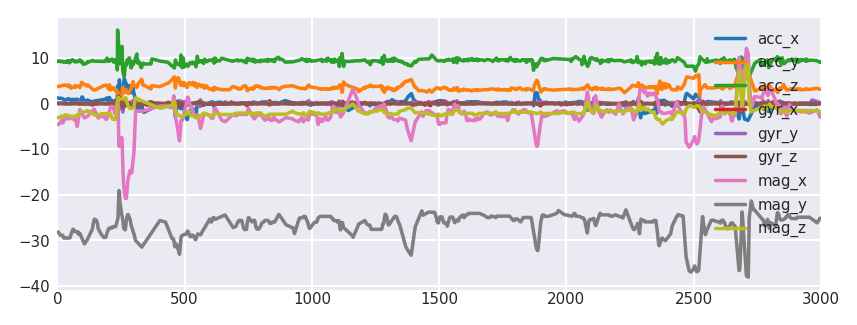

After Scaling:


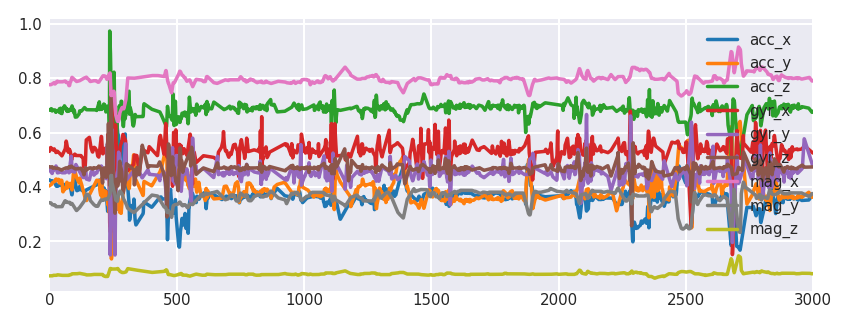

In [2]:
if P.scaler_global:
    print("Normalize all data before splitting into train and test sets...")
    hmog.all, scalers = utils_custom_scale(
        hmog.all,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,
    )
else:
    print("Skipped, normalize after splitting.")

### 2.3 Split Dataset for Valid/Test <a id='2.3'>&nbsp;</a> 
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

In [3]:
hmog.split_train_valid_train_test(
    n_valid_train=P.n_valid_train_subjects,
    n_valid_test=P.n_valid_test_subjects,
    n_test_train=P.n_test_train_subjects,
    n_test_test=P.n_test_test_subjects,
)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,index,0.08,2160,4,90,2160
1,valid_train,1252.56,12628905,12,40,960
2,valid_test,292.21,2946177,12,10,240
3,test_train,314.94,3175398,12,10,240
4,test_test,929.25,9369107,12,30,720


### 2.4 Normalize features (if not global) <a id='2.4'>&nbsp;</a> 

In [4]:
if not P.scaler_global:
    print("Scaling Data for Siamese Network only...")
    print("Training Data:")
    hmog.valid_train, _ = utils_custom_scale(
        hmog.valid_train,
        scale_cols=P.feature_cols,
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
    print("Validation Data:")
    hmog.valid_test, _ = utils_custom_scale(
        hmog.valid_test,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
else:
    print("Skipped, already normalized.")    

Skipped, already normalized.


### 2.5 Check Splits <a id='2.5'>&nbsp;</a> 

In [5]:
utils_split_report(hmog.valid_train)

Unique subjects: 40
Unique sessions: 960

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,0.426178,0.403722,0.683366,0.530999,0.469394,0.474613,0.776018,0.342368,0.073009,865501,865501_session_1,3
1,0.425232,0.404711,0.682200,0.535761,0.465437,0.474202,0.776018,0.341666,0.073009,865501,865501_session_1,3
2,0.424504,0.405357,0.683101,0.539228,0.462237,0.473739,0.776018,0.341403,0.073009,865501,865501_session_1,3
3,0.423777,0.406004,0.684002,0.541117,0.460475,0.473347,0.776018,0.341403,0.073009,865501,865501_session_1,3
4,0.423050,0.406650,0.684903,0.543006,0.458714,0.472955,0.776018,0.341403,0.073009,865501,865501_session_1,3




Sessions' Task Types per subject:


subject,100669,171538,218719,220962,240168,248252,326223,352716,366286,405035,431312,472761,525584,540641,553321,554303,588087,621276,622852,663153,675397,693572,717868,733568,745224,751131,763813,771782,803262,856302,862649,865501,865881,876011,892687,897652,913228,962159,973891,980953
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [6]:
utils_split_report(hmog.valid_test)

Unique subjects: 10
Unique sessions: 240

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,0.568032,0.647618,0.517735,0.533517,0.494451,0.411277,0.165845,0.788593,0.373114,808022,808022_session_1,5
1,0.562027,0.650615,0.522223,0.533215,0.496036,0.413103,0.165586,0.786983,0.374118,808022,808022_session_1,5
2,0.560024,0.652888,0.522784,0.532913,0.497621,0.414928,0.165327,0.785374,0.375122,808022,808022_session_1,5
3,0.560422,0.654726,0.520989,0.532611,0.499205,0.416753,0.165067,0.783765,0.376126,808022,808022_session_1,5
4,0.560820,0.656564,0.519194,0.532310,0.500790,0.418578,0.164808,0.782156,0.377130,808022,808022_session_1,5




Sessions' Task Types per subject:


subject,277905,396697,489146,578526,594887,776328,777078,799296,808022,923862
1,4,4,4,4,4,4,4,4,4,4
2,4,4,4,4,4,4,4,4,4,4
3,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4
5,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4


In [7]:
utils_split_report(hmog.test_train)

Unique subjects: 10
Unique sessions: 240

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,0.401401,0.663427,0.538557,0.325789,0.511792,0.411143,0.312037,0.489539,0.386831,785873,785873_session_1,5
1,0.391529,0.674727,0.527316,0.327763,0.542363,0.408843,0.306771,0.483516,0.375780,785873,785873_session_1,5
2,0.389346,0.677198,0.528747,0.328408,0.541534,0.414229,0.306771,0.480946,0.375780,785873,785873_session_1,5
3,0.386285,0.681101,0.532832,0.329667,0.544287,0.416786,0.306771,0.479118,0.375780,785873,785873_session_1,5
4,0.383479,0.684564,0.536219,0.330927,0.547040,0.419343,0.305612,0.476624,0.377411,785873,785873_session_1,5




Sessions' Task Types per subject:


subject,186676,201848,264325,368258,698266,710707,785873,815316,827212,879155
1,4,4,4,4,4,4,4,4,4,4
2,4,4,4,4,4,4,4,4,4,4
3,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4
5,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4


In [8]:
utils_split_report(hmog.test_test)

Unique subjects: 30
Unique sessions: 720

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,0.536280,0.699859,0.497760,0.447855,0.530121,0.575973,0.297694,0.844756,0.688140,579284,579284_session_1,4
1,0.526400,0.721529,0.488954,0.464691,0.539712,0.575375,0.294598,0.843186,0.684267,579284,579284_session_1,4
2,0.526605,0.740649,0.498918,0.481527,0.549304,0.574777,0.291503,0.841616,0.680395,579284,579284_session_1,4
3,0.542856,0.742380,0.494202,0.498363,0.558896,0.574179,0.288407,0.840046,0.676522,579284,579284_session_1,4
4,0.553668,0.756572,0.503275,0.515199,0.568487,0.573581,0.285311,0.838475,0.672650,579284,579284_session_1,4




Sessions' Task Types per subject:


subject,151985,180679,207696,257279,261313,278135,336172,342329,395129,398248,501973,527796,538363,556357,561993,579284,657486,720193,785899,841866,863985,872895,893198,893255,918136,937904,966655,984799,990622,998757
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


### 2.6 Reshape Features  <a id='2.6'>&nbsp;</a> 

**Reshape & cache Set for Training Siamese Network:**

In [9]:
df_siamese_train = utils_reshape_features(
    hmog.valid_train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

# Clean memory
del hmog.train
%reset_selective -f hmog.train

print("Validation data after reshaping:")
display(df_siamese_train.head())

# Store iterim data
df_siamese_train.to_msgpack(OUTPUT_PATH / "df_siamese_train.msg")

# Clean memory
%reset_selective -f df_siamese_train

Validation data after reshaping:


,X,subject,session,task_type
0,"[[0.7152666871541594, 0.8321175330865778, 0.40...",100669,100669_session_1,1
1,"[[0.6280137159945616, 0.8369246098345297, 0.45...",100669,100669_session_1,1
2,"[[0.7216791231361175, 0.8307161559344726, 0.42...",100669,100669_session_1,1
3,"[[0.0, 0.22132649137620777, 0.2862149139682470...",100669,100669_session_1,1
4,"[[0.13483906790254563, 0.17378897996381903, 0....",100669,100669_session_1,1


**Reshape & cache Set for Validating Siamese Network:** (also used to optimize OCSVM)

In [10]:
df_siamese_valid = utils_reshape_features(
    hmog.valid_test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.valid
%reset_selective -f hmog.valid

print("Testing data after reshaping:")
display(df_siamese_valid.head())

# Store iterim data
df_siamese_valid.to_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")

# Clean memory
%reset_selective -f df_siamese_valid

Testing data after reshaping:


,X,subject,session,task_type
0,"[[0.48642486671254703, 0.388044504148944, 0.63...",277905,277905_session_1,3
1,"[[0.4893388365422073, 0.4561303190244361, 0.59...",277905,277905_session_1,3
2,"[[0.4928135452178994, 0.4585563162292168, 0.59...",277905,277905_session_1,3
3,"[[0.48822964349797465, 0.42892331597224465, 0....",277905,277905_session_1,3
4,"[[0.44431306922897346, 0.4894271475856361, 0.5...",277905,277905_session_1,3


**Reshape & cache Set for Training/Validation OCSVM:**

In [11]:
df_ocsvm_train_valid = utils_reshape_features(
    hmog.test_train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test_train
%reset_selective -f hmog.test_train

print("Testing data after reshaping:")
display(df_ocsvm_train_valid.head())

# Store iterim data
df_ocsvm_train_valid.to_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")

# Clean memory
%reset_selective -f df_ocsvm_train_valid

Testing data after reshaping:


,X,subject,session,task_type
0,"[[0.28405073352246657, 0.6230773239920935, 0.1...",186676,186676_session_1,4
1,"[[0.5959411489665651, 0.8031653165613303, 0.50...",186676,186676_session_1,4
2,"[[0.6756268929946608, 0.8980725662448292, 0.36...",186676,186676_session_1,4
3,"[[0.6485716066464491, 0.8142130041255482, 0.51...",186676,186676_session_1,4
4,"[[0.6947038513953862, 0.7864652725645278, 0.59...",186676,186676_session_1,4


**Reshape & cache Set for Training/Testing OCSVM:**

In [12]:
df_ocsvm_train_test = utils_reshape_features(
    hmog.test_test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test_test
%reset_selective -f hmog.test_test

print("Testing data after reshaping:")
display(df_ocsvm_train_test.head())

# Store iterim data
df_ocsvm_train_test.to_msgpack(OUTPUT_PATH / "df_ocsvm_train_test.msg")

# Clean memory
%reset_selective -f df_ocsvm_train_test
%reset_selective -f df_

Testing data after reshaping:


,X,subject,session,task_type
0,"[[0.32982495119179966, 0.6089412551805774, 0.5...",151985,151985_session_1,1
1,"[[0.3278610750891465, 0.643191374574863, 0.555...",151985,151985_session_1,1
2,"[[0.2987681112119247, 0.6786299020950805, 0.53...",151985,151985_session_1,1
3,"[[0.26523920502278464, 0.6895884593508588, 0.5...",151985,151985_session_1,1
4,"[[0.28120292110146505, 0.6811718698395035, 0.5...",151985,151985_session_1,1


## 3. Generate Scenario Pairs <a id='3'>&nbsp;</a> 

### 3.1 Load cached Data <a id='3.1'>&nbsp;</a> 

In [13]:
df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train.msg")
df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")

### 3.2 Build positive/negative Pairs  <a id='3.2'>&nbsp;</a> 

In [14]:
def build_pairs(df):
    # Limit samples per subject to sample of shortest session
    df = df.groupby("session", group_keys=False).apply(
        lambda x: x.sample(min(len(x), P.max_pairs_per_session), random_state=SEED)
    )
    df_pairs = None

    # Split samples subject wise 50:50
    # ---------------
    df_positives = None
    df_negatives = None

    for subject in df["subject"].unique():
        # Shuffle
        df_subj = df[df["subject"] == subject].sample(frac=1, random_state=SEED)

        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        half = len(df_subj) // 2

        df_positives = pd.concat([df_positives, df_subj.iloc[:half]])
        df_negatives = pd.concat([df_negatives, df_subj.iloc[half:]])

    # Positive Pairs
    # ---------------
    df_positive_left = None
    df_positive_right = None

    for subject in df_positives["subject"].unique():
        df_subj = df[df["subject"] == subject]
        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        # Split in half
        half = len(df_subj) // 2
        df_positive_left = pd.concat([df_positive_left, df_subj.iloc[:half]])
        df_positive_right = pd.concat([df_positive_right, df_subj.iloc[half:]])

    df_positive_left = df_positive_left.reset_index(drop=True)
    df_positive_right = df_positive_right.reset_index(drop=True)
    df_positive_left.columns = ["left_" + c for c in df_positive_left.columns]
    df_positive_right.columns = ["right_" + c for c in df_positive_right.columns]

    df_positives = pd.concat(
        [df_positive_left, df_positive_right],
        axis=1,
        sort=False,
        join_axes=[df_positive_left.index],
    )

    # Negative Pairs
    # ---------------
    # Make rows even
    if len(df_negatives) % 2 != 0:
        df_negatives = df_negatives.iloc[:-1]

    # Split in half
    half = len(df_negatives) // 2
    df_negative_left = df_negatives.iloc[half:].reset_index(drop=True)
    df_negative_right = df_negatives.iloc[:half].reset_index(drop=True)

    # Name columns
    df_negative_left.columns = ["left_" + c for c in df_negative_left.columns]
    df_negative_right.columns = ["right_" + c for c in df_negative_right.columns]

    # Combine
    df_negatives = pd.concat(
        [df_negative_left, df_negative_right],
        axis=1,
        sort=False,
        join_axes=[df_negative_left.index],
    )

    # Combine both Pairs
    # ---------------
    # Balance pairs
    min_len = min(len(df_positives), len(df_negatives))
    df_positives = df_positives.sample(n=min_len, random_state=SEED)
    df_negatives = df_negatives.sample(n=min_len, random_state=SEED)

    # Combine
    df_pairs = pd.concat([df_positives, df_negatives], sort=False)

    # Shuffle
    df_pairs = df_pairs.sample(frac=1, random_state=SEED).reset_index(drop=True)

    # Set Label
    df_pairs["label"] = np.where(
        df_pairs["left_subject"] == df_pairs["right_subject"], 1, 0
    )

    return df_pairs

In [15]:
# Reduce observations/samples per
print("Sample per session before reduction:\n ")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

df_siamese_train = df_siamese_train.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), P.samples_per_subject_train), random_state=SEED)
)

df_siamese_valid = df_siamese_valid.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), P.samples_per_subject_test), random_state=SEED)
)

print("\n\nSample per session after reduction:\n")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

Sample per session before reduction:
 


771782_session_5    2248
733568_session_2    2087
218719_session_5    1777
Name: session, dtype: int64

396697_session_1    1651
489146_session_4    1164
923862_session_2    1102
Name: session, dtype: int64



Sample per session after reduction:



865501_session_11    68
352716_session_20    68
865881_session_7     68
Name: session, dtype: int64

776328_session_18    68
277905_session_17    68
277905_session_9     68
Name: session, dtype: int64

In [16]:
df_siamese_train_pairs = build_pairs(df_siamese_train)
df_siamese_valid_pairs = build_pairs(df_siamese_valid)

### 3.3 Inspect Pairs <a id='3.3'>&nbsp;</a> 

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28796 entries, 0 to 28795
Data columns (total 9 columns):
left_X             28796 non-null object
left_subject       28796 non-null object
left_session       28796 non-null object
left_task_type     28796 non-null int64
right_X            28796 non-null object
right_subject      28796 non-null object
right_session      28796 non-null object
right_task_type    28796 non-null int64
label              28796 non-null int64
dtypes: int64(3), object(6)
memory usage: 2.0+ MB


None



Head:


,left_X,left_subject,left_session,left_task_type,right_X,right_subject,right_session,right_task_type,label
0,"((0.8187503582417135, 0.595401988715006, 0.553...",980953,980953_session_14,6,"((0.6916329719260805, 0.32391411875621473, 0.5...",663153,663153_session_5,6,0
1,"((0.4013063984907301, 0.5909621343317146, 0.51...",763813,763813_session_12,2,"((0.4111106686218262, 0.6073695323962817, 0.40...",763813,763813_session_23,4,1
2,"((0.5899809120986967, 0.8529749291611868, 0.35...",771782,771782_session_11,3,"((0.5628175538958965, 0.6063249067941514, 0.49...",771782,771782_session_22,5,1
3,"((0.5084424898601092, 0.7636421106747904, 0.70...",856302,856302_session_12,5,"((0.4050270087648366, 0.6594677108791701, 0.75...",856302,856302_session_23,4,1
4,"((0.347857518012908, 0.8023536820697196, 0.515...",240168,240168_session_2,1,"((0.5295228424015621, 0.33546253373595086, 0.6...",240168,240168_session_9,2,1




Any NaN values?


left_X             0
left_subject       0
left_session       0
left_task_type     0
right_X            0
right_subject      0
right_session      0
right_task_type    0
label              0
dtype: int64




Distribution of Samples per Subjects in training Data


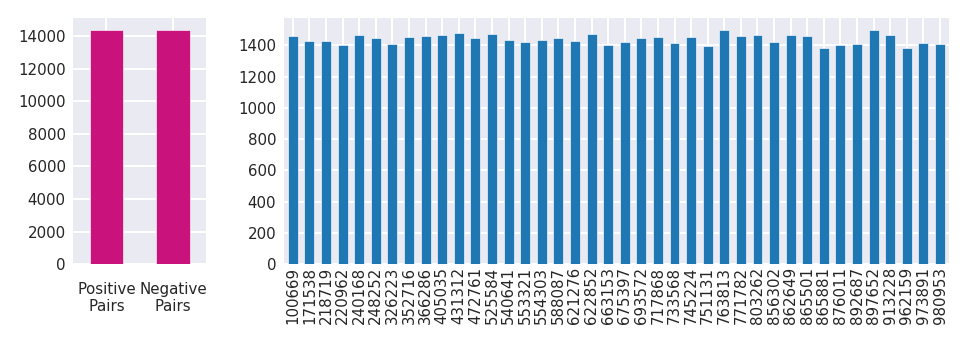

In [17]:
print("DataFrame Info:")
display(df_siamese_train_pairs.info())

print("\n\nHead:")
display(df_siamese_train_pairs.head(5))

print("\n\nAny NaN values?")
display(df_siamese_train_pairs.isnull().sum(axis = 0))

df_left_sub = df_siamese_train_pairs.groupby("left_subject")["left_subject"].count()
df_right_sub = df_siamese_train_pairs.groupby("right_subject")["right_subject"].count()
df_temp = pd.concat([df_left_sub, df_right_sub])

print("\n\n\nDistribution of Samples per Subjects in training Data")

fig, axes = plt.subplots(
    ncols=2, nrows=1, figsize=(5.473, 2), dpi=180, gridspec_kw={"width_ratios": [1, 5]}
)
df_siamese_train_pairs["label"].value_counts().rename(
    index={0: "Negative\nPairs", 1: "Positive\nPairs"}
).plot.bar(ax=axes[0], rot=0, color=MAGENTA)
axes[0].tick_params(axis="x", which="major", pad=7)
df_temp.groupby(df_temp.index).sum().plot.bar(ax=axes[1], width=0.6)
fig.tight_layout()

utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pair-dist.pdf")

### 3.4 Cache Pairs <a id='3.4'>&nbsp;</a> 

In [18]:
df_siamese_train_pairs.to_msgpack(OUTPUT_PATH / "df_siamese_train_pairs.msg")
df_siamese_valid_pairs.to_msgpack(OUTPUT_PATH / "df_siamese_valid_pairs.msg")

In [19]:
# Clean Memory
%reset_selective -f df_

## 4. Siamese Network <a id='4'>&nbsp;</a> 

### 4.1 Load cached Pairs <a id='4.1'>&nbsp;</a> 

In [20]:
df_siamese_train_pairs = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train_pairs.msg")
df_siamese_valid_pairs = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid_pairs.msg")

### 4.2 Build Model <a id='4.2'>&nbsp;</a> 

#### Distance Function

In [21]:
def k_euclidean_dist(t):
    x = t[0]
    y = t[1]    
    return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True))

#### Loss Function

In [22]:
def k_contrastive_loss(y_true, dist):
    """Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    margin = P.margin
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(margin - dist, 0)))

Sanity check contrastive loss function:

In [23]:
def contrastive_loss_test(y_true, dist):
    """Test function above using implementation with numpy instead tensors."""
    margin = P.margin
    return y_true * np.square(dist) + (1 - y_true) * np.square(np.max(margin - dist, 0))

In [24]:
print("Positive: class=1, distance=0,     loss:", contrastive_loss_test(1, 0))
print("Positive: class=1, distance=0.01,  loss:", contrastive_loss_test(1, 0.01))
print("Positive: class=1, distance=0.3,   loss:", contrastive_loss_test(1, 0.3))
print("Positive: class=1, distance=0.5,   loss:", contrastive_loss_test(1, 0.5))
print("Positive: class=1, distance=1,     loss:", contrastive_loss_test(1, 1))

Positive: class=1, distance=0,     loss: 0.0
Positive: class=1, distance=0.01,  loss: 0.0001
Positive: class=1, distance=0.3,   loss: 0.09
Positive: class=1, distance=0.5,   loss: 0.25
Positive: class=1, distance=1,     loss: 1.0


In [25]:
print("Negative: class=0, distance=0,     loss:", contrastive_loss_test(0, 0))
print("Negative: class=0, distance=0.01,  loss:", contrastive_loss_test(0, 0.01))
print("Negative: class=0, distance=0.3,   loss:", contrastive_loss_test(0, 0.3))
print("Negative: class=0, distance=0.5,   loss:", contrastive_loss_test(0, 0.5))
print("Negative: class=0, distance=5,     loss:", contrastive_loss_test(0, 1))

Negative: class=0, distance=0,     loss: 0.04000000000000001
Negative: class=0, distance=0.01,  loss: 0.0361
Negative: class=0, distance=0.3,   loss: 0.009999999999999995
Negative: class=0, distance=0.5,   loss: 0.09
Negative: class=0, distance=5,     loss: 0.6400000000000001


#### Siamese Model with 2D Filters, as derived from Centeno et al. (2018)

In [26]:
def build_model_2d(input_shape, filters):
    """
        Siamese CNN architecture with 3D input and 2D filters
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv2D(filters[0], (7, 7), padding="same", activation="tanh", name="conv1")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp1")(x)
    x = Conv2D(filters[1], (5, 5), padding="same", activation="tanh", name="conv2")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp2")(x)
    x = Conv2D(filters[2], (3, 3), padding="same", activation="tanh", name="conv3")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp3")(x)
    x = Conv2D(filters[3], (3, 3), padding="same", activation="tanh", name="conv4")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp4")(x)
    x = Flatten(name="flat")(x)
    
    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with 1D Filters, similar than Centeno et al. (2018)

In [27]:
def build_model_1d(input_shape, filters):
    """
        Model architecture
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(filters[0], 7, activation="elu", padding="same", name="conv1")(inputs)
    x = MaxPooling1D(pool_size=2, name="mp1")(x)
    x = Conv1D(filters[1], 5, activation="elu", padding="same", name="conv2")(x)
    x = MaxPooling1D(pool_size=2, name="mp2")(x)
    x = Conv1D(filters[2], 3, activation="elu", padding="same", name="conv3")(x)
    x = MaxPooling1D(pool_size=2, name="mp3")(x)
    x = Conv1D(filters[3], 3, activation="elu", padding="same", name="conv4")(x)
    x = MaxPooling1D(pool_size=2, name="mp5")(x)
    x = Flatten(name="flat")(x)

    # Generate the encodings (feature vectors) for the two images
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the absolute difference between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with FCN architecture

In [28]:
def build_model_fcn(input_shape, filters):
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(
        filters=filters[0],
        kernel_size=8,
        strides=1,
        activation=None,
        padding="same",
        name="conv1",
    )(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop1")(x)
    x = Conv1D(
        filters=filters[1],
        kernel_size=5,
        strides=1,
        activation=None,
        padding="same",
        name="conv2",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop2")(x)
    x = Conv1D(
        filters=filters[2],
        kernel_size=3,
        strides=1,
        activation=None,
        padding="same",
        name="conv3",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation="sigmoid", name="dense")(x) # <--- !!!!!!!!!!!!

    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

In [29]:
def get_model(name, window_size, feature_cols, filters):
    print(f"Using Model variant {name}...")
    if name == "1d":
        model, basemodel = build_model_1d((window_size, len(feature_cols)), filters)
    elif name == "2d":
        model, basemodel = build_model_2d((window_size, len(feature_cols), 1), filters)
    elif name == "fcn":
        model, basemodel = build_model_fcn((window_size, len(feature_cols)), filters)
    else:
        raise BaseException("Error: Not a valid model name: {1d, 2d, fcn}")

    return model, basemodel

**Inspect model architecture:**

In [30]:
temp_model, temp_basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

temp_basemodel.summary()
temp_model.summary()

Using Model variant 2d...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 25, 9, 1)          0         
_________________________________________________________________
conv1 (Conv2D)               (None, 25, 9, 32)         1600      
_________________________________________________________________
mp1 (MaxPooling2D)           (None, 13, 5, 32)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 13, 5, 64)         51264     
_________________________________________________________________
mp2 (MaxPooling2D)           (None, 7, 3, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 7, 3, 128)         73856     
_________________________________________________________________
mp3 (MaxPooling2D)           (None, 4, 2, 128)    

### 4.3 Prepare Features <a id='4.3'>&nbsp;</a> 

In [31]:
def prep_X_y_pair(df):
    
    X_left = np.stack(list(df["left_X"].values))
    X_right = np.stack(list(df["right_X"].values))
    
    X = [X_left, X_right]
    y = df["label"].values
    
    return X, y

In [32]:
X_train, y_train = prep_X_y_pair(df_siamese_train_pairs)
X_valid, y_valid = prep_X_y_pair(df_siamese_valid_pairs)

# 2D Filter Model needs flat 4th dimension
if P.model_variant == "2d":
    X_train[0] = X_train[0].reshape((*X_train[0].shape, 1))
    X_train[1] = X_train[1].reshape((*X_train[1].shape, 1))
    X_valid[0] = X_valid[0].reshape((*X_valid[0].shape, 1))
    X_valid[1] = X_valid[1].reshape((*X_valid[1].shape, 1))

print(
    f"Training samples:   {y_train.shape[0]}, shape: {X_train[0].shape},"
    + f" class balance: {np.unique(y_train, return_counts=True)}"
)
print(
    f"Validation samples: {y_valid.shape[0]}, shape: {X_valid[0].shape},"
    + f" class balance: {np.unique(y_valid, return_counts=True)}"
)

Training samples:   28796, shape: (28796, 25, 9, 1), class balance: (array([0, 1]), array([14398, 14398]))
Validation samples: 7200, shape: (7200, 25, 9, 1), class balance: (array([0, 1]), array([3600, 3600]))


### 4.4 Search optimal Epoch <a id='4.4'>&nbsp;</a> 

In [33]:
class MetricsCallback(Callback):
    """
    Custom Keras Callback function.
    
    Used to predict and plot distances for positive and negative pairs
    after each n-th epoch, along with some 'classification' metrics. 
    'Classification' here means to ability to distinguish between positive 
    and negative pairs using a threshold for the distance.
    
    Arguments:
        payload {tuple}           -- Datasets used for evaluation: (X_valid, y_valid, X_train, y_train)
        epoch_evaluate_freq {int} -- Frequency for evaluation. After every n-th epoch, 
                                     the results are evaluated and printed
        save_plots {boolean}      -- Do you want to save plots as PDF? Path is configured via global
                                     parameter REPORT_PATH.
    """

    def __init__(self, payload, epoch_evaluate_freq=1, save_plots=False):

        self.X_valid, self.y_valid, self.X_train, self.y_train = payload
        self.save_plots = save_plots
        self.epoch_evaluate_freq = epoch_evaluate_freq

        # Do we have train and valid set?
        self.sets = []
        if self.X_train:
            self.sets.append([self.X_train, self.y_train, "Train"])
        if self.X_valid:
            self.sets.append([self.X_valid, self.y_valid, "Valid"])

    def on_train_begin(self, logs={}):
        print(32 * "=" + f"[ Initial State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_train_end(self, logs={}):
        print(32 * "=" + f"[ Final State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_epoch_end(self, epoch, logs={}):
        print(32 * "=" + f"[   Epoch {epoch}   ]" + 32 * "=", end="")
        if epoch % self.epoch_evaluate_freq == 0:  # Evaluate only every n-th epoch
            for X, y, desc in self.sets:
                self.evaluate(X, y, logs, desc, epoch)
        else:
            print(f"\n{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }")

    def evaluate(self, X, y, logs, desc, epoch):
        # Predict
        y_score = self.model.predict(X)
        y_score_neg = y_score * -1  # lower distance means closer to positive class

        # Calc Metrics
        roc_val = metrics.roc_auc_score(y, y_score_neg)
        eer_val, thres = utils_eer(y, y_score_neg, True)
        y_pred = np.where(y_score_neg > thres, 1, 0)
        acc_val = metrics.accuracy_score(y, y_pred)
        f1_val = metrics.f1_score(y, y_pred)

        print(
            f"\n{desc.upper()}: roc_auc: {roc_val:.4f}, "
            + f"eer: {eer_val:.4f}, thres: {thres*-1:.4f} => "
            + f"acc: {acc_val:.4f}, f1: {f1_val:.4f}\n"
            + f"{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }"
        )

        # Plot distances
        mask = np.where(y == 1, True, False)
        dist_positive = y_score[mask]
        dist_negative = y_score[~mask]
        plt = utils_plot_distance_hist(
            dist_positive, dist_negative, thres * -1, desc=desc, margin=P.margin
        )

        if self.save_plots:
            utils_save_plot(
                plt,
                REPORT_PATH
                / f"buech2019-siamese-{P.name.lower()}-epoch-{epoch+1}-{desc.lower()}.pdf",
            )

        plt.show()

In [34]:
def get_optimizer(name, lr=None, decay=None):
    if name == "sgd":
        lr = lr if lr != None else 0.01
        decay = decay if decay != None else 0
        optimizer = SGD(lr=lr, decay=decay)
    elif name == "adam":
        lr = lr if lr != None else 0.001
        decay = decay if decay != None else 0
        optimizer = Adam(lr=lr, decay=decay)
    elif name == "rmsprop":
        lr = lr if lr != None else 0.001
        optimizer = RMSprop(lr=lr)
    else:
        raise BaseException("Error: Not a valid model name: 1d or 2d.")
    return optimizer

Using Model variant 2d...
================================[ Initial State ]================================
TRAIN: roc_auc: 0.6859, eer: 0.3639, thres: 0.0933 => acc: 0.6361, f1: 0.6361



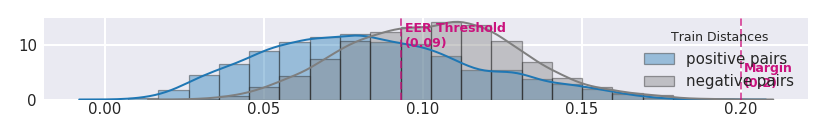


VALID: roc_auc: 0.7533, eer: 0.3119, thres: 0.0960 => acc: 0.6879, f1: 0.6879



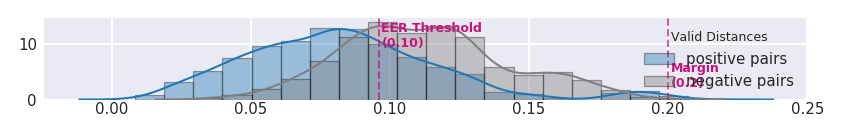

================================[   Epoch 0   ]================================
TRAIN: roc_auc: 0.7615, eer: 0.3064, thres: 0.0925 => acc: 0.6936, f1: 0.6936
val_loss: 0.008, loss: 0.009


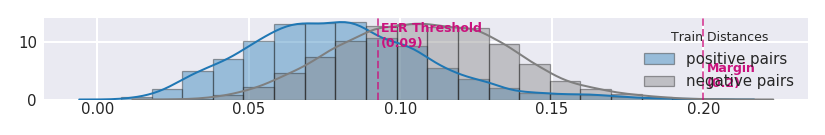


VALID: roc_auc: 0.7747, eer: 0.2936, thres: 0.0957 => acc: 0.7064, f1: 0.7064
val_loss: 0.008, loss: 0.009


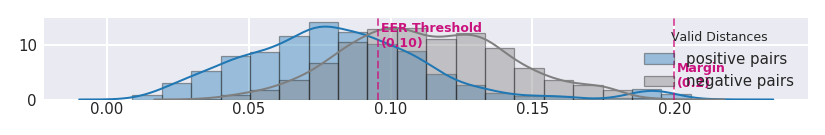

================================[   Epoch 1   ]================================
val_loss: 0.008, loss: 0.008
================================[   Epoch 2   ]================================
val_loss: 0.008, loss: 0.008
================================[   Epoch 3   ]================================
val_loss: 0.008, loss: 0.007
================================[   Epoch 4   ]================================
val_loss: 0.008, loss: 0.007
================================[   Epoch 5   ]================================
TRAIN: roc_auc: 0.8777, eer: 0.1933, thres: 0.0969 => acc: 0.8067, f1: 0.8067
val_loss: 0.007, loss: 0.007


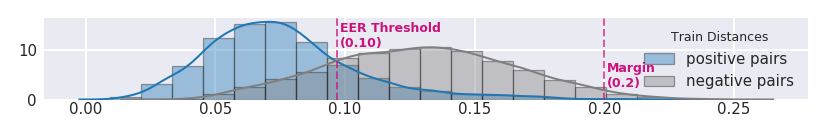


VALID: roc_auc: 0.8346, eer: 0.2228, thres: 0.0999 => acc: 0.7774, f1: 0.7773
val_loss: 0.007, loss: 0.007


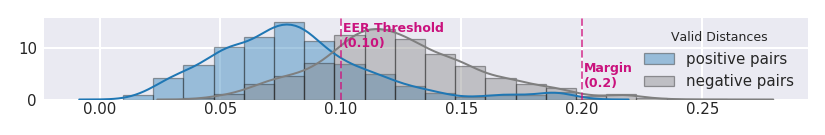

================================[   Epoch 6   ]================================
val_loss: 0.007, loss: 0.006
================================[   Epoch 7   ]================================
val_loss: 0.007, loss: 0.006
================================[   Epoch 8   ]================================
val_loss: 0.006, loss: 0.006
================================[   Epoch 9   ]================================
val_loss: 0.006, loss: 0.006
================================[   Epoch 10   ]================================
TRAIN: roc_auc: 0.9255, eer: 0.1437, thres: 0.0989 => acc: 0.8563, f1: 0.8563
val_loss: 0.006, loss: 0.005


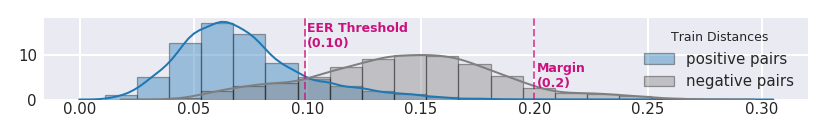


VALID: roc_auc: 0.8935, eer: 0.1733, thres: 0.1002 => acc: 0.8265, f1: 0.8265
val_loss: 0.006, loss: 0.005


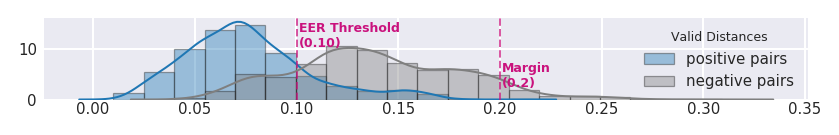

================================[   Epoch 11   ]================================
val_loss: 0.006, loss: 0.005
================================[   Epoch 12   ]================================
val_loss: 0.006, loss: 0.005
================================[   Epoch 13   ]================================
val_loss: 0.006, loss: 0.005
================================[   Epoch 14   ]================================
val_loss: 0.005, loss: 0.005
================================[   Epoch 15   ]================================
TRAIN: roc_auc: 0.9486, eer: 0.1222, thres: 0.0992 => acc: 0.8778, f1: 0.8778
val_loss: 0.005, loss: 0.005


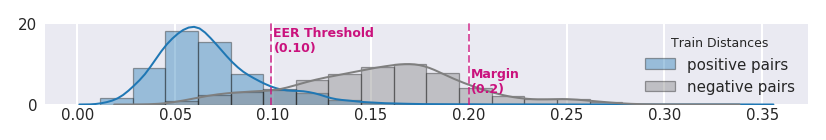


VALID: roc_auc: 0.9218, eer: 0.1578, thres: 0.0992 => acc: 0.8422, f1: 0.8422
val_loss: 0.005, loss: 0.005


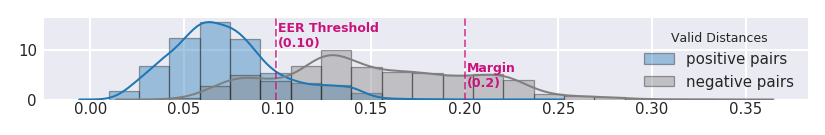

================================[   Epoch 16   ]================================
val_loss: 0.005, loss: 0.005
================================[   Epoch 17   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 18   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 19   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 20   ]================================
TRAIN: roc_auc: 0.9602, eer: 0.1056, thres: 0.0993 => acc: 0.8943, f1: 0.8943
val_loss: 0.005, loss: 0.004


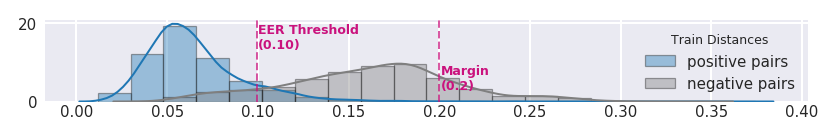


VALID: roc_auc: 0.9361, eer: 0.1521, thres: 0.0982 => acc: 0.8476, f1: 0.8477
val_loss: 0.005, loss: 0.004


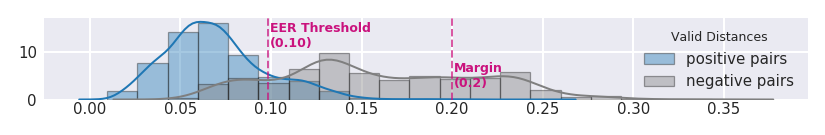

================================[   Epoch 21   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 22   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 23   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 24   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 25   ]================================
TRAIN: roc_auc: 0.9670, eer: 0.0946, thres: 0.0987 => acc: 0.9054, f1: 0.9054
val_loss: 0.005, loss: 0.004


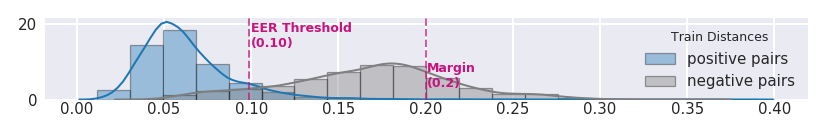


VALID: roc_auc: 0.9434, eer: 0.1489, thres: 0.0977 => acc: 0.8511, f1: 0.8511
val_loss: 0.005, loss: 0.004


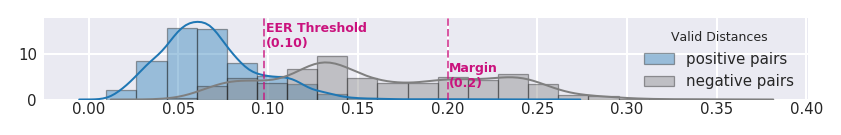

================================[   Epoch 26   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 27   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 28   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 29   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 30   ]================================
TRAIN: roc_auc: 0.9716, eer: 0.0863, thres: 0.0977 => acc: 0.9137, f1: 0.9137
val_loss: 0.005, loss: 0.004


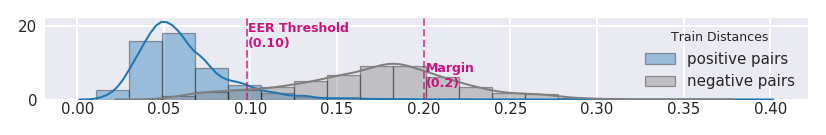


VALID: roc_auc: 0.9485, eer: 0.1435, thres: 0.0971 => acc: 0.8564, f1: 0.8564
val_loss: 0.005, loss: 0.004


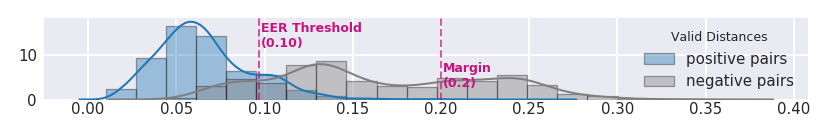

================================[   Epoch 31   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 32   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 33   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 34   ]================================
val_loss: 0.005, loss: 0.004
================================[   Epoch 35   ]================================
TRAIN: roc_auc: 0.9749, eer: 0.0804, thres: 0.0970 => acc: 0.9197, f1: 0.9197
val_loss: 0.005, loss: 0.003


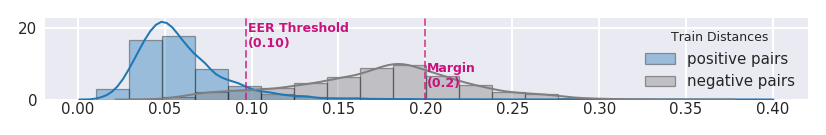


VALID: roc_auc: 0.9524, eer: 0.1381, thres: 0.0962 => acc: 0.8619, f1: 0.8619
val_loss: 0.005, loss: 0.003


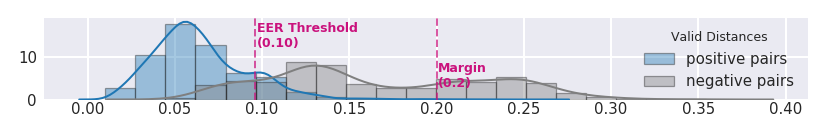

================================[   Epoch 36   ]================================
val_loss: 0.005, loss: 0.003
================================[   Epoch 37   ]================================
val_loss: 0.005, loss: 0.003
================================[   Epoch 38   ]================================
val_loss: 0.004, loss: 0.003
================================[   Epoch 39   ]================================
val_loss: 0.004, loss: 0.003
================================[ Final State ]================================
TRAIN: roc_auc: 0.9768, eer: 0.0774, thres: 0.0970 => acc: 0.9227, f1: 0.9227



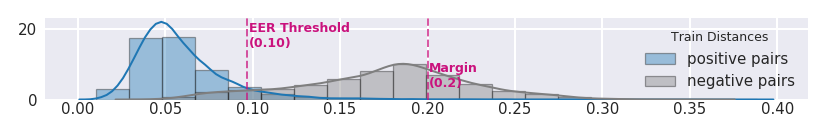


VALID: roc_auc: 0.9551, eer: 0.1339, thres: 0.0953 => acc: 0.8662, f1: 0.8663



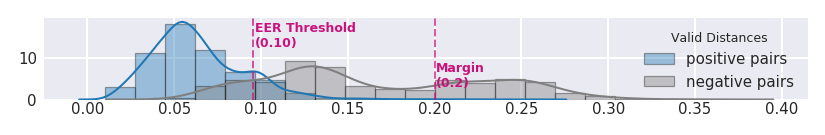

Training History:


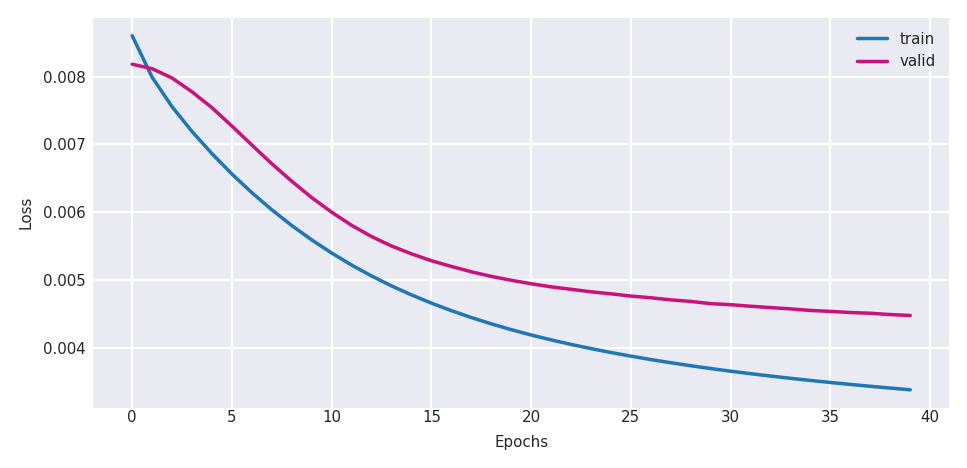

In [35]:
# Select model architecture
model, basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

# Select Optimizer
optimizer = get_optimizer(P.optimizer, P.optimizer_lr)

# Compile
warnings.filterwarnings("ignore")
model.compile(loss=k_contrastive_loss, optimizer=optimizer)

# Train
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=P.batch_size,
    epochs=P.epochs_max,
    verbose=0,
    validation_data=(X_valid, y_valid),
    callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=5, save_plots=True)],
)

print("Training History:")
plt = utils_plot_training_loss(history)
utils_save_plot(
    plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-epoch-trainloss.pdf"
)
plt.show()

### 4.5 Check Distances <a id='4.5'>&nbsp;</a> 

Mean distance: 0.11535
Max distance: 0.35590
Min distance: 0.01027


Histogram of Pair Distances:


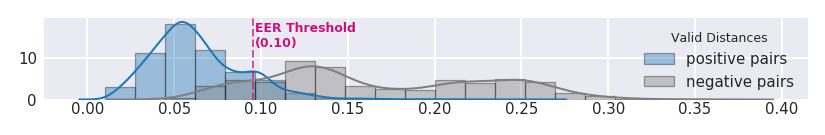

In [36]:
# Predic validation set
dists = model.predict(X_valid)

# Stats
print(f"Mean distance: {dists.mean():.5f}")
print(f"Max distance: {dists.max():.5f}")
print(f"Min distance: {dists.min():.5f}\n")

# Histrogram
print("\nHistogram of Pair Distances:")
eer_val, thres = utils_eer(y_valid, dists, True)
mask = np.where(y_valid == 1, True, False)
dist_positive = dists[mask]
dist_negative = dists[~mask]
plt = utils_plot_distance_hist(dist_positive, dist_negative, thres, "Valid")
plt.show()

### 4.6 Rebuild and train to optimal Epoch  <a id='4.6'>&nbsp;</a> 
Now, that we know the learning curve, we can rebuild the model and train it until the best Epoch.

Also, we will include the validation data to have more training data. 

**Note:** This also means, that the training metrics are not valid anymore, because we don't have any validation data left to test against...

Using Model variant 2d...
================================[ Initial State ]================================
TRAIN: roc_auc: 0.6651, eer: 0.3829, thres: 0.1173 => acc: 0.6171, f1: 0.6171



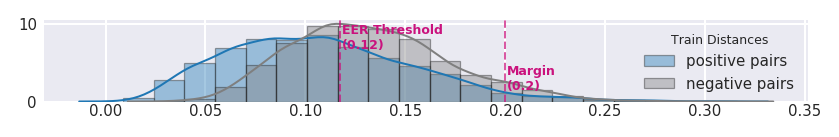

================================[   Epoch 0   ]================================
TRAIN: roc_auc: 0.7746, eer: 0.2969, thres: 0.0966 => acc: 0.7031, f1: 0.7031
loss: 0.009


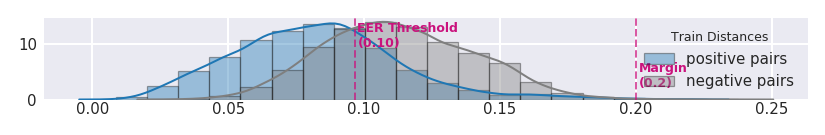

================================[   Epoch 1   ]================================
loss: 0.008
================================[   Epoch 2   ]================================
loss: 0.007
================================[   Epoch 3   ]================================
loss: 0.007
================================[   Epoch 4   ]================================
loss: 0.006
================================[   Epoch 5   ]================================
loss: 0.006
================================[   Epoch 6   ]================================
loss: 0.005
================================[   Epoch 7   ]================================
loss: 0.005
================================[   Epoch 8   ]================================
loss: 0.005
================================[   Epoch 9   ]================================
loss: 0.005
================================[   Epoch 10   ]================================
TRAIN: roc_auc: 0.9474, eer: 0.1220, thres: 0.0970 => acc: 0.8780, f1: 0.8780
loss: 0.005


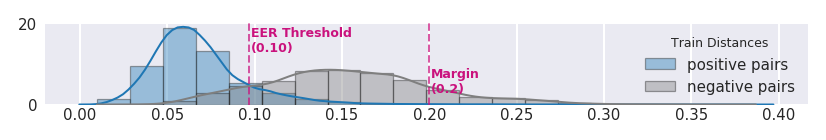

================================[   Epoch 11   ]================================
loss: 0.005
================================[   Epoch 12   ]================================
loss: 0.004
================================[   Epoch 13   ]================================
loss: 0.004
================================[   Epoch 14   ]================================
loss: 0.004
================================[   Epoch 15   ]================================
loss: 0.004
================================[   Epoch 16   ]================================
loss: 0.004
================================[   Epoch 17   ]================================
loss: 0.004
================================[   Epoch 18   ]================================
loss: 0.004
================================[   Epoch 19   ]================================
loss: 0.004
================================[   Epoch 20   ]================================
TRAIN: roc_auc: 0.9666, eer: 0.0945, thres: 0.0970 => acc: 0.9055, f1: 0.9055
loss

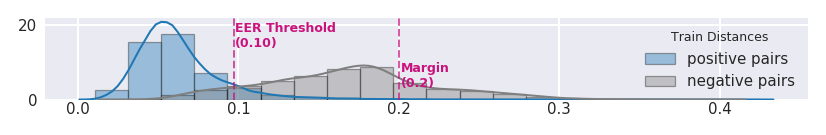

================================[   Epoch 21   ]================================
loss: 0.004
================================[   Epoch 22   ]================================
loss: 0.004
================================[   Epoch 23   ]================================
loss: 0.004
================================[   Epoch 24   ]================================
loss: 0.004
================================[   Epoch 25   ]================================
loss: 0.004
================================[   Epoch 26   ]================================
loss: 0.004
================================[   Epoch 27   ]================================
loss: 0.004
================================[   Epoch 28   ]================================
loss: 0.004
================================[   Epoch 29   ]================================
loss: 0.003
================================[   Epoch 30   ]================================
TRAIN: roc_auc: 0.9746, eer: 0.0795, thres: 0.0968 => acc: 0.9204, f1: 0.9204
loss

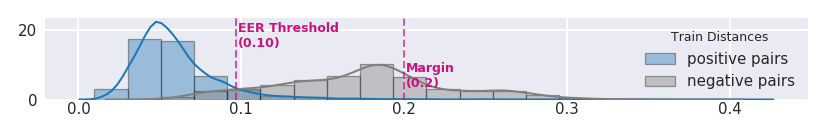

================================[   Epoch 31   ]================================
loss: 0.003
================================[   Epoch 32   ]================================
loss: 0.003
================================[   Epoch 33   ]================================
loss: 0.003
================================[   Epoch 34   ]================================
loss: 0.003
================================[ Final State ]================================
TRAIN: roc_auc: 0.9769, eer: 0.0758, thres: 0.0972 => acc: 0.9243, f1: 0.9243



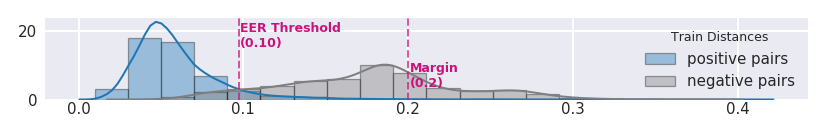

In [37]:
# Concat train & valid data
X_train_valid = [[], []]
X_train_valid[0] = np.vstack([X_train[0], X_valid[0]])
X_train_valid[1] = np.vstack([X_train[1], X_valid[1]])
y_train_valid = np.hstack([y_train, y_valid])

# Select model architecture
model, basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

# Select Optimizer
optimizer = get_optimizer(P.optimizer, P.optimizer_lr)
    
# Compile
model.compile(loss=k_contrastive_loss, optimizer=optimizer)

# Train
history = model.fit(
    x=X_train_valid,
    y=y_train_valid,
    batch_size=P.batch_size,
    epochs=P.epochs_best,
    verbose=0,
    callbacks=[MetricsCallback((None, None, X_train, y_train), epoch_evaluate_freq=10, save_plots=False)],
)

### 4.7 Cache model <a id='4.7'>&nbsp;</a> 

In [38]:
model.save(str((OUTPUT_PATH / f"{P.name}_model.h5").resolve()))

In [39]:
# Clean Memory
%reset_selective -f df_
%reset_selective -f X_
%reset_selective -f y_

## 5. Visualize Deep Features <a id='5'>&nbsp;</a> 

### 5.1 Load cached Data <a id='5.1'>&nbsp;</a> 

In [40]:
print (OUTPUT_PATH/ "df_siamese_valid.msg")
df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")
df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train.msg")

df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")

/gpfs/fs0/scratch/u/uhengart/ezzeldi/vae_hmog/ContinAuth/notebooks/output/chapter-6-1-4-siamese-cnn/df_siamese_valid.msg


### 5.2 Extract CNN from Siamese Model <a id='5.2'>&nbsp;</a> 
I do this by redirecting inputs and outputs.

However, the network still needs a pair as input (I wasn't able to change this). This slows down a little bit the prediction (as the input is predicted twice), but doesn't change the results.

In [41]:
def load_deep_feature_model(model_path):
    # Copy of function from above. It's just more convenient for partially 
    # executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )
    
    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )
    
    return deep_feature_model

In [42]:
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")
deep_feature_model.summary()

/home/u/uhengart/ezzeldi/.local/lib/python3.6/site-packages/keras/engine/saving.py:251: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weight_names:


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
left_inputs (InputLayer)     (None, 25, 9, 1)          0         
_________________________________________________________________
basemodel (Model)            (None, 64)                163616    
Total params: 163,616
Trainable params: 163,616
Non-trainable params: 0
_________________________________________________________________


### 5.3 Test Generation of Deep Features <a id='5.3'>&nbsp;</a> 

In [43]:
def prep_X_y_single(df):
    X = np.stack(list(df["X"].values))
    y = df["label"].values
    return X, y

In [44]:
def transform_to_sample_by_subject(df):
    sample_by_subject = []
    df["label"] = 1
    for subj in df["subject"].unique():
        df_subj = df[df["subject"] == subj]
        X_sub, y_sub = prep_X_y_single(df_subj)
        sample_by_subject.append((X_sub, y_sub, subj))
    return sample_by_subject

#### Select subset (for plotting) and transform features

In [45]:
# Concat Valid & Train (both were used for last Training)
df_train_temp = pd.concat([df_siamese_valid, df_siamese_train])
df_test_temp = df_ocsvm_train_valid

# Select data from 20 subjects of the TRAINING SET
random.seed(SEED)
ten_subjects = random.sample(df_train_temp["subject"].unique().tolist(), 20)
df_train_temp = df_train_temp[df_train_temp["subject"].isin(ten_subjects)].copy()
df_train_temp = df_train_temp.groupby("subject").apply(lambda x: x.sample(n=300, random_state=SEED))  # Plot only subset of samples

# Select data from 10 subjects of the TEST SET (not included in training)
random.seed(SEED)
ten_subjects = random.sample(df_test_temp["subject"].unique().tolist(), 10)
df_test_temp = df_test_temp[df_ocsvm_train_valid["subject"].isin(ten_subjects)].copy()
df_test_temp = df_test_temp.groupby("subject").apply(lambda x: x.sample(n=300, random_state=SEED))  # Plot only subset of samples

# Transform Samples
samples_train = transform_to_sample_by_subject(df_train_temp)
samples_test = transform_to_sample_by_subject(df_test_temp)

print(f"First subject: {samples_train[0][2]}")
print(f"y shape: {samples_train[0][1].shape}")
print(f"X shape: {samples_train[0][0].shape}")

First subject: 218719
y shape: (300,)
X shape: (300, 25, 9)


#### Predict Deep Features

In [46]:
deep_features_train = None
for X, y, subj in samples_train:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_train = pd.concat([deep_features_train, df_features])
        
deep_features_test = None
for X, y, subj in samples_test:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_test = pd.concat([deep_features_test, df_features])
        
display(deep_features_train.head(3))
display(deep_features_test.head(3))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,subject
0,0.140439,0.007270,0.093024,0.030628,0.116673,0.166947,0.054950,0.204678,-0.006290,0.201427,0.027899,0.028839,0.102509,0.114227,0.134217,0.087663,0.128599,0.051485,0.095374,0.015366,0.014419,0.066669,-0.036946,0.247351,0.060634,0.010896,-0.036870,0.203179,0.075768,-0.047001,-0.015185,0.136490,0.147879,-0.053876,0.132279,0.057741,0.109392,0.143883,0.001989,0.135826,0.035469,0.081226,0.037494,0.005878,0.037131,-0.004822,0.146045,0.039700,0.046336,0.052704,0.016571,-0.033824,0.003890,0.051210,-0.047030,0.197775,0.089411,-0.018454,0.026101,0.171352,0.057527,0.019260,-0.008195,0.112268,218719
1,0.138344,0.003659,0.089171,0.034096,0.118629,0.160138,0.052937,0.201571,-0.007377,0.202747,0.026793,0.032705,0.098311,0.108313,0.133862,0.088372,0.122425,0.048760,0.099351,0.019266,0.019005,0.064193,-0.033687,0.246243,0.065562,0.012842,-0.030848,0.205805,0.071603,-0.042503,-0.018460,0.138223,0.145765,-0.056847,0.130651,0.058210,0.103119,0.138114,0.007664,0.129464,0.032699,0.084025,0.036686,0.003488,0.037009,-0.002131,0.140729,0.040431,0.044679,0.047537,0.016423,-0.030508,0.002011,0.045572,-0.045116,0.196078,0.098206,-0.010317,0.027025,0.175979,0.058994,0.014461,-0.009127,0.106937,218719
2,0.140910,0.015301,0.094419,0.039457,0.113214,0.174464,0.048274,0.205731,-0.006720,0.203209,0.034358,0.029932,0.101643,0.108476,0.136221,0.088773,0.122711,0.048753,0.097016,0.014315,0.010468,0.064996,-0.036974,0.241679,0.048375,0.012197,-0.037788,0.198218,0.073098,-0.053794,-0.022283,0.142285,0.147037,-0.041689,0.133555,0.062487,0.105696,0.153689,0.000694,0.140843,0.029451,0.078404,0.043020,0.007721,0.038096,-0.011949,0.146670,0.041565,0.036835,0.049486,0.011229,-0.034712,0.007799,0.051246,-0.045290,0.192798,0.077068,-0.020418,0.011273,0.165567,0.058151,0.023307,-0.007566,0.113574,218719


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,subject
0,0.127151,-0.002143,0.113080,-0.065829,0.067855,0.082200,0.068028,0.185016,-0.004792,0.214817,0.022783,0.025124,0.131075,0.076870,0.093915,0.078541,0.097162,0.022628,0.068776,-0.002644,0.013603,0.040086,-0.033845,0.218153,0.104770,-0.008524,-0.016773,0.308412,0.058411,-0.043442,-0.063549,0.103960,0.143640,-0.044619,0.148324,0.014376,0.071837,0.077125,0.044985,0.141660,0.043718,0.083958,0.041347,-0.032160,0.052182,-0.002590,0.115454,0.024421,0.029901,0.011176,0.027682,-0.070938,0.006050,0.025744,-0.041364,0.184676,0.132413,0.015394,0.003649,0.256839,0.049117,0.027534,-0.029902,0.063095,186676
1,0.128423,-0.004036,0.114009,-0.064948,0.071201,0.083169,0.069418,0.175359,-0.002113,0.212766,0.020652,0.025530,0.125520,0.075417,0.096603,0.081531,0.100557,0.026706,0.063270,-0.001206,0.011222,0.037518,-0.030696,0.216972,0.102670,-0.002448,-0.014762,0.305311,0.060815,-0.048237,-0.062490,0.105753,0.140816,-0.046750,0.145071,0.009061,0.069557,0.078068,0.043066,0.134871,0.042808,0.088652,0.038233,-0.028846,0.048567,0.002292,0.120126,0.025390,0.031277,0.010960,0.028497,-0.068135,0.003867,0.021367,-0.041686,0.182693,0.125666,0.016048,0.002837,0.250032,0.049445,0.022537,-0.026198,0.070826,186676
2,0.130618,-0.001421,0.112278,-0.061433,0.066962,0.088560,0.068268,0.184396,-0.005887,0.214353,0.021152,0.023845,0.127062,0.078431,0.097091,0.081948,0.099689,0.028197,0.071279,-0.004187,0.012338,0.039871,-0.033209,0.219321,0.099553,-0.008669,-0.018750,0.300777,0.058516,-0.046131,-0.060116,0.105060,0.145044,-0.045434,0.148288,0.012261,0.070444,0.076850,0.044101,0.140099,0.043297,0.085102,0.039770,-0.033781,0.049574,0.000995,0.117164,0.024788,0.027753,0.009841,0.029301,-0.071091,0.005972,0.024414,-0.041895,0.185304,0.130352,0.016575,0.006636,0.255286,0.049607,0.027951,-0.029531,0.068251,186676


### 5.4 Visualize in 2D using PCA <a id='5.4'>&nbsp;</a> 

In [47]:
def plot_pca(df):
    # PCA
    pca = PCA(n_components=2)
    deep_transformed = pca.fit_transform(df.drop(columns=["subject"]).values)

    # Create df with data needed for chart only
    df_viz = df.copy()
    df_viz["PCA0"] = deep_transformed[:, 0]
    df_viz["PCA1"] = deep_transformed[:, 1]
    df_viz.drop(
        columns=[c for c in df_viz.columns if c not in ["PCA0", "PCA1", "subject"]]
    )

    # Generate color index for every subject
    df_viz["Subject"] = pd.Categorical(df_viz["subject"])
    df_viz["colors"] = df_viz["Subject"].cat.codes

    if len(df_viz["Subject"].unique()) <= 10:
        pal = sns.color_palette("tab10")
    else:
        pal = sns.color_palette("tab20")
        
    # Actual plot
    fig = plt.figure(figsize=(5.473 / 1.5, 5.473 / 2), dpi=180)
    sns.scatterplot(
        x="PCA0",
        y="PCA1",
        data=df_viz,
        hue="Subject",
        legend="full",
        palette=pal,
        s=2,
        linewidth=0,
        alpha=0.6,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=5)
    fig.tight_layout()
    return plt

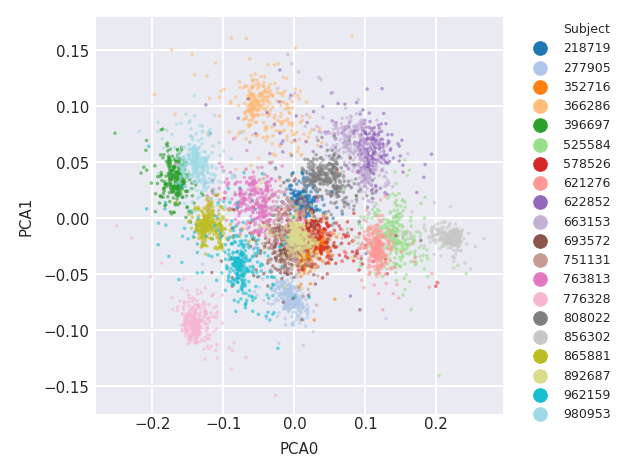

In [48]:
plot_pca(deep_features_train)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pca-train.pdf")

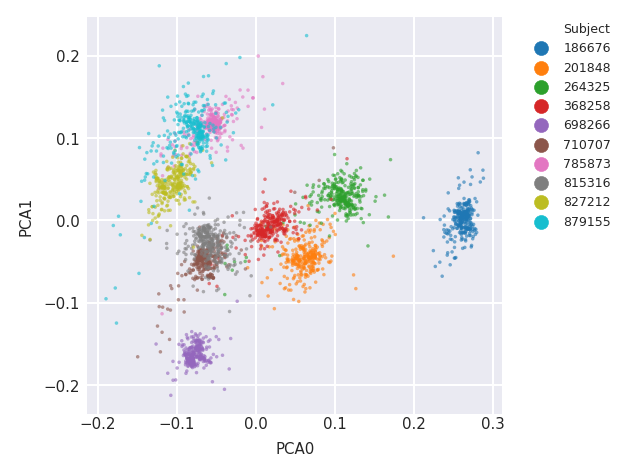

In [49]:
plot_pca(deep_features_test)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pca-test.pdf")

In [50]:
### Cleanup memory
%reset_selective -f df_
%reset_selective -f X_
%reset_selective -f y_
%reset_selective -f pca

## 6. OCSVM <a id='6'>&nbsp;</a> 

### 6.1 Load cached Data <a id='6.1'>&nbsp;</a> 

### 6.2 Load trained Siamese Model <a id='6.2'>&nbsp;</a> 

**Helper methods to load model:**

**Sanity Check:**

### 6.3 Search for Parameters <a id='6.3'>&nbsp;</a> 

In [51]:
df_ocsvm_train_valid.head()

NameError: name 'df_ocsvm_train_valid' is not defined

In [ ]:
param_dist = {"gamma": np.logspace(-3, 3), "nu": np.linspace(0.0001, 0.3)}

# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with randomsearch scores

for run in tqdm(range(3)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_valid["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf")

        warnings.filterwarnings("ignore")
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            error_score=np.nan,
            random_state=SEED,
        )

        random_search.fit(X, y)

        df_report = utils_cv_report(random_search, owner, impostors)
        df_report["run"] = run
        df_results = pd.concat([df_results, df_report], sort=False)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv", index=False)

# etahoun edit here - trying out the VAE model on deep features! 


In [ ]:
def vae_utils_cv_report(random_search, owner, impostors):
    """Transform the random_search.cv_results_ into nice formatted dataframe."""
    # Create report
    df_report = pd.DataFrame(random_search.cv_results_)

    # Add owner information
    df_report["owner"] = owner

    # Drop uninteressting columns
    drop_columns = [col for col in df_report.columns if "_train_" in col]
    drop_columns = drop_columns + [col for col in df_report.columns if col.startswith("split") and (col.endswith("recall") or col.endswith("precision") or col.endswith("f1") or col.endswith("roc_auc"))]
    drop_columns = drop_columns + ["params"]
    df_report = df_report.drop(columns=drop_columns)

    # Flip sign of eer (revert flip by sklearn scorer)
    eer_columns = [col for col in df_report.columns if col.endswith("_eer")]
    df_report[eer_columns] = df_report[eer_columns].abs()
    
    # Rename split result columns with impostor-ids used in split
    rename_cols = {}
    for idx, impostor in enumerate(impostors):
        to_rename_cols = [col for col in df_report.columns if col.startswith(f"split{idx}")]
        for col in to_rename_cols:
            rename_cols[col] = str(impostor)+col[len(f"split{idx}"):]
    df_report = df_report.rename(columns=rename_cols)      

    return df_report

In [ ]:

param_dist = {"gamma": np.logspace(-3, 3), "nu": np.linspace(0.0001, 0.3)}


# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with randomsearch scores

for run in tqdm(range(1)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_valid["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf")

        warnings.filterwarnings("ignore")
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            error_score=np.nan,
            random_state=SEED,
        )

        random_search.fit(X, y)

        df_report = utils_cv_report(random_search, owner, impostors)
        df_report["run"] = run
        df_results = pd.concat([df_results, df_report], sort=False)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv", index=False)

In [ ]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

In [ ]:
df_results.iloc[:20]

# solving nan scores 

In [ ]:
(10000, 784)

In [ ]:
X.shape[1]

In [ ]:
y.shape

In [ ]:
from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [ ]:
def autoencoder_model(X):
    X = X.reshape(X.shape[0], 1, X.shape[1])
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mae')    
    return model

model = autoencoder_model(X)

model.summary()

history = model.fit(X_3, X_3, epochs=50, batch_size=50,validation_split=0.05).history

In [ ]:


# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()



In [ ]:
import keras
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def yadeeny_VAE(): 
    # network parameters
    size_a=1
    size_b=32
    original_dim = size_a*size_b
    input_shape = (original_dim, )
    intermediate_dim = 26
    batch_size = 12
    latent_dim = 2
    epochs = 50

    # VAE model = encoder + decoder
    # build encoder model
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')
    
    reconstruction_loss = mse(inputs, outputs) 
    #OR
    #reconstruction_loss = binary_crossentropy(inputs,outputs)
    
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    
    
    return vae 
model = yadeeny_VAE() 
model.fit(X,y)

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras as k
from tensorflow.keras import layers

def make_model(SIZE=28, LATENT_DIM=10, LR=1e-4, BETA=1.):
    encoder_inputs = layers.Input(shape=(SIZE, SIZE, 1), name='encoder_input')
    e = layers.Conv2D(filters=16,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(encoder_inputs)
    e = layers.BatchNormalization()(e)
    e = layers.Conv2D(filters=32,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(e)
    e = layers.BatchNormalization()(e)
    e = layers.Flatten()(e)
    z_mean = layers.Dense(LATENT_DIM, name='z_mean')(e)
    z_log_var = layers.Dense(LATENT_DIM, name='z_log_var')(e)
    encoder = k.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var], name='encoder')


    decoder_inputs = layers.Input(shape=(LATENT_DIM,), name='decoder_input')
    d = layers.Dense(units=7*7*4,activation='relu')(decoder_inputs)
    d = layers.Reshape((7,7,4))(d)
    d = layers.Conv2DTranspose(filters=16,kernel_size=4,strides=(2, 2), padding="SAME", activation='relu')(d)
    d = layers.Conv2DTranspose(filters=32,kernel_size=4,strides=(2, 2), padding="SAME", activation='relu')(d)
    decoded = layers.Conv2DTranspose(filters=1, kernel_size=3,strides=(1, 1), padding="SAME")(d)
    decoder = k.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')


    def sample(inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    sampler = layers.Lambda(sample)
    z = sampler([z_mean, z_log_var])
    vae = k.Model(inputs=encoder_inputs, outputs=decoder(z), name='vae')

    def compute_kernel(x, y):
        x_size = tf.shape(x)[0]
        y_size = tf.shape(y)[0]
        dim = tf.shape(x)[1]
        tiled_x = tf.tile(tf.reshape(x, [x_size, 1, dim]), [1, y_size, 1])
        tiled_y = tf.tile(tf.reshape(y, [1, y_size, dim]), [x_size, 1, 1])
        return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))


    def compute_mmd(x, y):
        x_kernel = compute_kernel(x, x)
        y_kernel = compute_kernel(y, y)
        xy_kernel = compute_kernel(x, y)
        return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

    true_samples = tf.random_normal(shape=tf.shape(z))
    loss_mmd = compute_mmd(true_samples, z)
    vae.add_loss(loss_mmd*BETA)
        
    vae.compile(loss='mse', optimizer=k.optimizers.Adam(LR), metrics=['mse'])
    return encoder, decoder , vae

e,d,VAE_yarab = make_model()
VAE_yarab.fit(X,y)

In [ ]:

rzlts = pd.DataFrame()
VAE_param_dist = {"learning_rate": np.logspace(10**0, 10**-3)}

# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

vae_df_results = None  # Will be filled with randomsearch scores

for run in tqdm(range(1)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_valid["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values
        print(y)
        print(len(y))
        
        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = autoencoder_model(X)#VA()
        random_search = RandomizedSearchCV(
            model,
            param_distributions=VAE_param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            #error_score=np.nan,
            random_state=SEED,
        )
        

        random_search.fit(X, y)
        rzlts=pd.DataFrame(random_search.cv_results_)
        rzlts.head()
        break
    break

In [ ]:
rzlts

In [ ]:
model = VA()
model.fit(X,y)

In [ ]:
model.score()

In [ ]:
VAE_param_dist = {"learning_rate": np.logspace(10**0, 10**-3)}

# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

vae_df_results = None  # Will be filled with randomsearch scores

for run in tqdm(range(1)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_valid["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = VA()

        warnings.filterwarnings("ignore")
        random_search = RandomizedSearchCV(
            model,
            param_distributions=VAE_param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            #scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            #error_score=np.nan,
            random_state=SEED,
        )

        random_search.fit(X, y)

        vae_df_report = utils_cv_report(random_search, owner, impostors)
        vae_df_report["run"] = run
        vae_df_results = pd.concat([vae_df_results, vae_df_report], sort=False)

vae_df_results.to_csv(OUTPUT_PATH / f"VAE_random_search_results.csv", index=False)

In [ ]:
df_results.head()

In [ ]:
vae_df_results.head()

In [ ]:
df_report = pd.DataFrame(random_search.cv_results_)
df_report.head()

In [ ]:
vae_df_results = pd.read_csv(OUTPUT_PATH / f"VAE_random_search_results.csv")
print("Best results for each owner:")

display(
    vae_df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "param_learning_rate",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

In [ ]:
VAE_model.get_params().keys()

In [ ]:
"""SGVB
"""
# Authors: Joost van Amersfoort <joost.van.amersfoort@gmail.com>
#          Otto Fabius <ottofabius@gmail.com>
#          
# License: MIT

import time
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals.six.moves import xrange
from sklearn.utils import check_array, check_random_state, gen_even_slices #atleast2d_or_csr


class VA(BaseEstimator, TransformerMixin):

    """Stochastic Gradient Variational Bayes
    An auto-encoder with variational Bayes inference.
    Parameters
    ----------
    n_components_decoder : int, optional
        Number of binary hidden units for decoder.
    n_components_encoder : int, optional
        Number of binary hidden units for encoder.
    n_hidden_variables : int, optional
        The dimensionality of Z
    learning_rate : float, optional
        The learning rate for weight updates. It is *highly* recommended
        to tune this hyper-parameter. Reasonable values are in the
        10**[0., -3.] range.
    batch_size : int, optional
        Number of examples per minibatch.
    n_iter : int, optional
        Number of iterations/sweeps over the training dataset to perform
        during training.
    sampling_rounds : int, optional
        Number of sampling rounds done on the minibatch
    continuous : boolean, optional
        Set what type of data the auto-encoder should model
    verbose : int, optional
        The verbosity level. The default, zero, means silent mode.
    random_state : integer or numpy.RandomState, optional
        A random number generator instance to define the state of the
        random permutations generator. If an integer is given, it fixes the
        seed. Defaults to the global numpy random number generator.
    Attributes
    ----------
    'params' : list-like, list of weights and biases.
    Examples
    --------
    ----------
    References
    [1] Kingma D.P., Welling M. Stochastic Gradient VB and the Variational Auto-Encoder
    Arxiv, preprint. http://arxiv.org/pdf/1312.6114v6.pdf
    """

    def __init__(self, n_components_decoder=200, n_components_encoder=200,
                 n_hidden_variables=20, learning_rate=0.02, batch_size=100,
                 n_iter=40, sampling_rounds=1, continuous=False, verbose=0,
                 random_state=None,nu=None):
        self.n_components_decoder = n_components_decoder
        self.n_components_encoder = n_components_encoder
        self.n_hidden_variables = n_hidden_variables

        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_iter = n_iter
        self.sampling_rounds = sampling_rounds
        self.verbose = verbose

        self.continuous = continuous
        self.random_state = random_state

    def _initParams(self, dimX, rng):
        """Create all weight and bias parameters with the right dimensions
        Parameters
        ----------
        dimX : scalar
            The dimensionality of the input data X
        """
        sigmaInit = 0.01
        W1 = rng.normal(0, sigmaInit, (self.n_components_encoder, dimX))
        b1 = rng.normal(0, sigmaInit, (self.n_components_encoder, 1))

        W2 = rng.normal(
            0, sigmaInit, (self.n_hidden_variables, self.n_components_encoder))
        b2 = rng.normal(0, sigmaInit, (self.n_hidden_variables, 1))

        W3 = rng.normal(
            0, sigmaInit, (self.n_hidden_variables, self.n_components_encoder))
        b3 = rng.normal(0, sigmaInit, (self.n_hidden_variables, 1))

        W4 = rng.normal(
            0, sigmaInit, (self.n_components_decoder, self.n_hidden_variables))
        b4 = rng.normal(0, sigmaInit, (self.n_components_decoder, 1))

        W5 = rng.normal(0, sigmaInit, (dimX, self.n_components_decoder))
        b5 = rng.normal(0, sigmaInit, (dimX, 1))

        self.params = {"W1": W1, "W2": W2, "W3": W3, "W4": W4, "W5": W5,
                        "b1": b1, "b2": b2, "b3": b3, "b4": b4, "b5": b5}

        if self.continuous:
            W6 = rng.normal(
                0, sigmaInit, (dimX, self.n_components_decoder))
            b6 = rng.normal(0, sigmaInit, (dimX, 1))
            self.params.update({"W6": W6, "b6": b6})

        self.h = dict()
        for key in self.params:
            self.h[key] = 0.01

    def _initH(self, minibatch, rng):
        """Initialize H for AdaGrad
        Parameters
        ----------
        minibatch: array-like, shape (n_features, batch_size)
            The data to use for computing gradients to update H
        """

    
        gradients, lowerbound = self._computeGradients(minibatch.T, rng)

        for key in gradients:
            self.h[key] += gradients[key] ** 2

    def _computeGradients(self, x, rng):
        """Perform backpropagation
        Parameters
        ----------
        x: array-like, shape (n_features, batch_size)
            The data to use for computing gradients to update the weights and biases
        Returns
        -------
        gradients : dictionary with ten or twelve array-like gradients to the weights and biases
        lowerbound : int
            Lower bound on the log likelihood per data point
        """
        W1, W2, W3, W4, W5 = self.params["W1"], self.params["W2"], self.params["W3"],\
        self.params["W4"], self.params["W5"]
        b1, b2, b3, b4, b5 = self.params["b1"], self.params["b2"], self.params["b3"],\
        self.params["b4"], self.params["b5"]

        if self.continuous:
            W6, b6 = self.params["W6"], self.params["b6"]
            activation = lambda x: np.log(1 + np.exp(x))
        else:
            activation = lambda x: np.tanh(x,x)

        sigmoid = lambda x: 1. / (1 + np.exp(-x))

        #Feed forward
        h_encoder = activation(W1.dot(x) + b1)

        mu_encoder = W2.dot(h_encoder) + b2
        log_sigma_encoder = 0.5 * (W3.dot(h_encoder) + b3)

        eps = rng.normal(0, 1, [self.n_hidden_variables, x.shape[1]])
        z = mu_encoder + np.exp(log_sigma_encoder) * eps

        h_decoder = activation(W4.dot(z) + b4)

        y = sigmoid(W5.dot(h_decoder) + b5)

        if self.continuous:
            log_sigma_decoder = 0.5 * (W6.dot(h_decoder) + b6)
            logpxz = np.sum(-(0.5 * np.log(2 * np.pi) + log_sigma_decoder) -
                            0.5 * ((x - y) / np.exp(log_sigma_decoder)) ** 2)
        else:
            logpxz = np.sum(x * np.log(y) + (1 - x) * np.log(1 - y))

        KLD = 0.5 * np.sum(1 + 2 * log_sigma_encoder -
                           mu_encoder ** 2 - np.exp(2 * log_sigma_encoder))
        lowerbound = logpxz + KLD

        # Compute gradients
        if self.continuous:
            dp_dy = (np.exp(-2 * log_sigma_decoder) * 2 * (x - y)) / 2
            dp_dlogsigd = np.exp(-2 * log_sigma_decoder) * (x - y) ** 2 - 1
        else:
            dp_dy = (x / y - (1 - x) / (1 - y))

        # W5
        dy_dSig = (y * (1 - y))
        dp_dW5 = (dp_dy * dy_dSig).dot(h_decoder.T)
        dp_db5 = np.sum(dp_dy * dy_dSig, axis=1, keepdims=True)

        if self.continuous:
            # W6
            dp_dW6 = (dp_dlogsigd * dy_dSig).dot(0.5 * h_decoder.T)
            dp_db6 = np.sum(dp_dlogsigd * dy_dSig, axis=1, keepdims=True)

        dSig_dHd = W5
        dp_dHd = ((dp_dy * dy_dSig).T.dot(dSig_dHd)).T

        if self.continuous:
            dHd_df = np.exp(W4.dot(z) + b4) / (np.exp(W4.dot(z) + b4) + 1)
        else:
            dHd_df = 1 - h_decoder ** 2

        # W4
        dp_dW4 = (dp_dHd * dHd_df).dot(z.T)
        dp_db4 = np.sum(dp_dHd * dHd_df, axis=1, keepdims=True)

        dtanh_dz = W4
        dmue_dW2 = h_encoder

        dp_dz = (dp_dHd * dHd_df).T.dot(dtanh_dz)
        dp_dmue = dp_dz.T

        dp_dW2 = dp_dmue.dot(dmue_dW2.T)
        dp_db2 = dp_dmue

        dKLD_dmue = -mu_encoder
        dKLD_dW2 = dKLD_dmue.dot(dmue_dW2.T)
        dKLD_db2 = dKLD_dmue

        # W2
        dp_dW2 += dKLD_dW2
        dp_db2 = np.sum(dp_db2 + dKLD_db2, axis=1, keepdims=True)

        dz_dlogsige = eps * np.exp(log_sigma_encoder)
        dp_dlogsige = dp_dz.T * dz_dlogsige

        dlogsige_dW3 = 0.5 * h_encoder
        dlogsige_db3 = 0.5

        dp_dW3 = dp_dlogsige.dot(dlogsige_dW3.T)
        dp_db3 = dp_dlogsige * dlogsige_db3

        dKLD_dlogsige = 1 - np.exp(2 * log_sigma_encoder)
        dKLD_dW3 = dKLD_dlogsige.dot(dlogsige_dW3.T)
        dKLD_db3 = dKLD_dlogsige * dlogsige_db3

        # W3
        dp_dW3 += dKLD_dW3
        dp_db3 = np.sum(dp_db3 + dKLD_db3, axis=1, keepdims=True)

        # W1, log p(x|z)
        ###########################################
        dmue_dHe = W2
        if self.continuous:
            dHe_df = np.exp(W1.dot(x) + b1) / (np.exp(W1.dot(x) + b1) + 1)
        else:
            dHe_df = 1 - h_encoder ** 2

        dtanh_dW1 = x

        # W1: log(P(x|z)), mu encoder side
        dp_dHe = dp_dmue.T.dot(dmue_dHe)
        dp_dtanh = dp_dHe.T * dHe_df
        dp_dW1_1 = (dp_dtanh).dot(dtanh_dW1.T)
        dp_db1_1 = dp_dtanh

        # W1: log(P(x|z)), log sigma encoder side
        dlogsige_dHe = 0.5 * W3
        dp_dHe_2 = dp_dlogsige.T.dot(dlogsige_dHe)

        dp_dtanh_2 = dp_dHe_2.T * dHe_df
        dp_dW1_2 = (dp_dtanh_2).dot(dtanh_dW1.T)
        dp_db1_2 = dp_dtanh_2

        dp_dW1 = dp_dW1_1 + dp_dW1_2
        dp_db1 = dp_db1_1 + dp_db1_2
        ##########################################

        #W1, DKL
        ###########################################
        dKLD_dHe_1 = dKLD_dlogsige.T.dot(dlogsige_dHe)
        dKLD_dHe_2 = dKLD_dmue.T.dot(dmue_dHe)

        dKLD_dtanh = dKLD_dHe_1.T * dHe_df
        dKLD_dW1_1 = (dKLD_dtanh).dot(dtanh_dW1.T)
        dKLD_db1_1 = dKLD_dtanh

        dKLD_dtanh_2 = dKLD_dHe_2.T * dHe_df
        dKLD_dW1_2 = (dKLD_dtanh_2).dot(dtanh_dW1.T)
        dKLD_db1_2 = dKLD_dtanh_2

        dKLD_dW1 = dKLD_dW1_1 + dKLD_dW1_2
        dKLD_db1 = dKLD_db1_1 + dKLD_db1_2
        ############################################

        # W1
        dp_dW1 += dKLD_dW1
        dp_db1 = np.sum(dp_db1 + dKLD_db1, axis=1, keepdims=True)

        gradients = {"W1": dp_dW1, "W2": dp_dW2, "W3": dp_dW3, "W4": dp_dW4, "W5": dp_dW5,
                     "b1": dp_db1, "b2": dp_db2, "b3": dp_db3, "b4": dp_db4, "b5": dp_db5}

        if self.continuous:
            gradients.update({"W6": dp_dW6, "b6": dp_db6})

        return [gradients, lowerbound]

    def _updateParams(self, minibatch, N, rng):
        """Perform one update on the parameters
        Parameters
        ----------
        minibatch : array-like, shape (n_features, batch_size)
            The data to use for computing gradients to update the weights and biases
        N : int
            The total number of datapoints, used for prior correction
        Returns
        -------
        lowerbound : int
            Lower bound on the log likelihood per data point
        """
        for l in xrange(self.sampling_rounds):
            gradients, lowerbound = self._computeGradients(minibatch.T, rng)

            if 'total_gradients' not in locals():
                total_gradients = gradients
            else:
                for key in gradients:
                    total_gradients[key] += gradients[key]

        for key in self.params:
            self.h[key] += total_gradients[key] ** 2
            if "W" in key:
                prior = 0.5 * self.params[key]
            else:
                prior = 0

            self.params[key] += self.learning_rate / np.sqrt(self.h[key]) * \
                (total_gradients[key] - prior * (minibatch.shape[0] / N))

        return lowerbound

    def fit(self, X,y):
        """Fit SGVB to the data
        Parameters
        ----------
        X : array-like, shape (N, n_features)
            The data that the SGVB needs to fit on
        Returns
        -------
        list_lowerbound : list of int
        list of lowerbound over time
        """
        X = check_array(X, accept_sparse='csr')#, dtype=np.float)
        [N, dimX] = X.shape
        rng = check_random_state(self.random_state)

        self._initParams(dimX, rng)
        list_lowerbound = np.array([])

        n_batches = int(np.ceil(float(N) / self.batch_size))
        batch_slices = list(gen_even_slices(n_batches * self.batch_size,
                                            n_batches, N))

        if self.verbose:
            print ("Initializing gradients for AdaGrad")
        for i in xrange(len(batch_slices)):
            self._initH(X[batch_slices[i]], rng)

        begin = time.time()
        for iteration in xrange(1, self.n_iter + 1):
            iteration_lowerbound = 0

            for batch_slice in batch_slices:
                lowerbound = self._updateParams(X[batch_slice], N, rng)
                iteration_lowerbound += lowerbound

            if self.verbose:
                end = time.time()
                print("[%s] Iteration %d, lower bound = %.2f,"
                      " time = %.2fs"
                      % (self.__class__.__name__, iteration,
                         iteration_lowerbound / N, end - begin))
                begin = end

            list_lowerbound = np.append(
                list_lowerbound, iteration_lowerbound / N)
        return list_lowerbound

    def transform(self, X):
        """Transform the data
        Parameters
        ----------
        X : array-like, shape (N, n_features)
            The data that needs to be transformed
        Returns
        -------
        X : array-like, shape (N, n_components_decoder)
            The transformed data
        """
        X, = check_array(X, accept_sparse='csr')#, dtype=np.float)

        if self.continuous:
            return np.log(1 + np.exp(X.dot(self.params["W1"].T) + self.params["b1"].T))
        else:
            return np.tanh(X.dot(self.params["W1"].T) + self.params["b1"].T)

    def fit_transform(self, X):
        """Fit and transform the data, wrapper for fit and transform
        Parameters
        ----------
        X : array-like, shape (N, n_features)
            The data that needs to be fitted to and transformed
        Returns
        -------
        X : array-like, shape (N, n_components_decoder)
            The transformed data
        """
        self.fit(X)
        return self.transform(X)

    def score(self, X,y):
        """Computer lower bound on data, very naive implementation
        Parameters
        ----------
        data : array-like, shape (N, n_features)
            The data that needs to be fitted to and transformed
        Returns
        -------
        lower bound : int
            The lower bound on the log likelihood 
        """
        v = check_array(X)
        rng = check_random_state(self.random_state)

        gradients, lowerbound = self._computeGradients(v.T, rng)
        return lowerbound/X.shape[0]

# experimenting here yet again

In [ ]:
X.shape

In [ ]:
# Shape of input and latent variable

n_input = 28*28

# Encoder structure
n_encoder1 = 500
n_encoder2 = 300

n_latent = 2

# Decoder structure
n_decoder2 = 300
n_decoder1 = 500

reg = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1), 
                   activation = 'tanh', 
                   solver = 'adam', 
                   learning_rate_init = 0.0001, 
                   max_iter = 20, 
                   tol = 0.0000001, 
                   verbose = True)



In [ ]:

import scipy
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest


param_dist = {"gamma": np.logspace(-3, 3), "nu": np.linspace(0.0001, 0.3)} #ocsvm 
param_dist = {"n_estimators": np.arange(start=1, stop=100, step=5), "max_features": np.arange(start=1, stop=500, step=5.5)} #if
param_dist = {"n_neighbors": np.arange(start=1, stop=100, step=1), "p":np.arange(start=1, stop=4, step=1),"leaf_size": np.arange(start=1, stop=100, step=1)} #lof
param_dist = {
    'solver': ['sgd', 'adam', 'lbfgs'],
    'activation': ['relu', 'tanh'],
    'learning_rate':['constant', 'invscaling', 'adaptive'],
    'alpha':np.linspace(0.0001, 0.3), 
    'momentum':np.linspace(0.0001, 0.99)
    
} #mlp 




# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with randomsearch scores

for run in tqdm(range(1)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_valid["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = MLPClassifier()#LocalOutlierFactor(novelty=True)#OneClassSVM(kernel="rbf")#IsolationForest()#

        warnings.filterwarnings("ignore")
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            error_score=np.nan,
            random_state=SEED,
        )

        random_search.fit(X, y)

        df_report = utils_cv_report(random_search, owner, impostors)
        df_report["run"] = run
        df_results = pd.concat([df_results, df_report], sort=False)

df_results.to_csv(OUTPUT_PATH / f"MLP_{P.name}_random_search_results.csv", index=False)

# mlp with parm 

In [ ]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

# ocsvm with parm 

In [ ]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

# ocsvm

In [ ]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

# if with param with bootstrap

In [ ]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

# if with param

In [ ]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

# if

In [ ]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

# lof

In [ ]:
df_results.head()

# lof

In [ ]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

# lof with param

In [ ]:
df_results.nsmallest(3,['mean_test_eer'])['mean_test_eer']

In [ ]:
param_dist = {"gamma": np.logspace(-3, 3), "nu": np.linspace(0.0001, 0.3)}

# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with randomsearch scores

for run in tqdm(range(1)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_valid["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        ''' model = OneClassSVM(kernel="rbf")

        warnings.filterwarnings("ignore")
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            error_score=np.nan,
            random_state=SEED,
        )

        random_search.fit(X, y)
        '''
        df_report = utils_cv_report(random_search, owner, impostors)
        df_report["run"] = run
        df_results = pd.concat([df_results, df_report], sort=False)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv", index=False)

### 6.4 Inspect Search Results <a id='6.4'>&nbsp;</a> 
**Raw Results & Stats:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv")
print("Best results for each owner:")

display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "param_nu",
            "param_gamma",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "mean_fit_time",
            "param_nu",
            "param_gamma",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

**Plot parameters of top n of 30 results for every Owner:**

In [ ]:
utils_plot_randomsearch_results(df_results, 1)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-parameters.pdf")

In [ ]:
def vae_utils_plot_randomsearch_results(df_results, n_top=1):
    # Prepare data for plotting
    df_plot = df_results[df_results["rank_test_eer"] <= n_top].rename(
        columns={
            "param_n_hidden_variables": r"$\n_hidden_variables$",
            "param_learning_rate": r"$\learning_rate$",
            "mean_test_accuracy": "Mean Test Acc.",
            "mean_test_eer": "Mean Test EER",
        }
    )
    df_plot["Mean Test EER"] = df_plot["Mean Test EER"] * -1  # Because fewer is more

    median_n_hidden_variables = df_plot[r"$\n_hidden_variables$"].median()
    median_learning_rate = df_plot[r"$\learning_rate$"].median()

    # Plot
    fig = plt.figure(figsize=(5.473 / 1.3, 2), dpi=180)
    g = sns.scatterplot(
        x=r"$\n_hidden_variables$",
        y=r"$\learning_rate$",
        data=df_plot,
        size="Mean Test EER",
        sizes=(7, 60),
        hue="Mean Test EER",
        alpha=1,
        #        palette="Blues",
        linewidth=0,
    )

    # Format Legend labels
    leg = g.get_legend()
    new_handles = [h for h in leg.legendHandles]
    new_labels = []
    for i, handle in en_hidden_variablesmerate(leg.legendHandles):
        label = handle.get_label()
        try:
            new_labels.append(f"{abs(float(label)):.3f}")
        except ValueError:
            new_labels.append("")

    # Plot mean values
    plt.plot(
        [-0.01, 0.31],
        [median_learning_rate, median_learning_rate],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        0.23,
        median_learning_rate * 1.7 ** 2,
        r"median($\learning_rate$)",
        fontsize=6,
        color="black",
        alpha=0.9,
    )
    plt.text(
        0.23,
        median_learning_rate * 1.2 ** 2,
        f"{median_learning_rate:.3f}",
        fontsize=5,
        color="black",
        alpha=0.9,
    )

    plt.plot(
        [median_n_hidden_variables, median_n_hidden_variables],
        [0.0001, 1000],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        median_n_hidden_variables + 0.005, 400, r"median($\n_hidden_variables$)", fontsize=6, color="black", alpha=0.9
    )
    plt.text(
        median_n_hidden_variables + 0.005, 200, f"{median_n_hidden_variables:.3f}", fontsize=5, color="black", alpha=0.9
    )

    # Adjust axes & legend
    plt.yscale("log")
    plt.ylim(0.0001, 1000)
    plt.xlim(0, 0.305)
    plt.legend(
        new_handles,
        new_labels,
        bbox_to_anchor=(1.02, 1),
        loc=2,
        borderaxespad=0.0,
        title="Mean EER per Owner\n(Validation Results)",
        title_fontsize=5,
    )

    fig.tight_layout()
    return fig

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"VAE_random_search_results.csv")
print("Best results for each owner:")

display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "param_learning_rate",
            "param_n_hidden_variables",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "mean_fit_time",
            "param_learning_rate",
            "param_n_hidden_variables",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

vae_utils_plot_randomsearch_results(df_results, 1)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-VAE-parameters.pdf")

## 7. Testing <a id='7'>&nbsp;</a> 

### 7.1 Load cached Data <a id='7.1'>&nbsp;</a> 
During testing, a split with different users than used for hyperparameter optimization is used:

In [ ]:
df_ocsvm_train_test = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_test.msg")

### 7.2 Evaluate Authentication Performance <a id='7.2'>&nbsp;</a> 
- Using Testing Split, Scenario Cross Validation, and multiple runs to lower impact of random session/sample selection.

In [ ]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(1), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_test_results.csv", index=False)
df_results.head()

In [ ]:
df_results.nlargest(3,'test_accuracy')

In [ ]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(1), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = VA(verbose=1) #OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            #scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            n_jobs=CORES,
            verbose=1,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        vae_df_results = pd.concat([vae_df_results, df_score], axis=0)

vae_df_results.to_csv(OUTPUT_PATH / f"vae_test_results.csv", index=False)
vae_df_results.head()
vae_df_results.nlargest(3,'test_accuracy')

# testing VAE ^  

In [ ]:
model

**Load Results from "EER & Accuracy" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_test_results.csv")
df_plot = df_results.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})

**Plot Distribution of Accuracy per subject:**

In [ ]:
fig = utils_plot_acc_eer_dist(df_plot, "Test Accuracy")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-acc.pdf")

**Plot Distribution of EER per subject:**

In [ ]:
fig = utils_plot_acc_eer_dist(df_plot, "Test EER")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-eer.pdf")

### 7.3 Evaluate increasing Training Set Size (Training Delay) <a id='7.3'>&nbsp;</a> 

In [ ]:
training_set_sizes = [1, 2, 3, 4, 10, 30, 60, 90, 125, 175, 250, 375]  # In samples

deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for n_train_samples in tqdm(training_set_sizes, desc="Train Size", leave=False):
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_ocsvm_train_test,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                limit_train_samples=n_train_samples,  # samples overall
                seed=SEED + i,
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                deep_model=deep_feature_model,
                model_variant=P.model_variant,
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_ocsvm_train_test["subject"].nunique(),
            leave=False,
        ):
            X = np.array(df_cv_scenarios["X"].values.tolist())
            y = df_cv_scenarios["label"].values

            train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

            model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

            warnings.filterwarnings("ignore")
            scores = cross_validate(
                model,
                X,
                y,
                cv=train_test_cv,
                scoring={"eer": utils_eer_scorer},
                n_jobs=CORES,
                verbose=0,
                return_train_score=True,
            )
            df_score = pd.DataFrame(scores)
            df_score["owner"] = owner
            df_score["train_samples"] = n_train_samples
            df_score["train_eer"] = df_score[
                "train_eer"
            ].abs()  # Revert scorer's signflip
            df_score["test_eer"] = df_score["test_eer"].abs()
            df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv", index=False)
df_results.head()

**Load Results from "Training set size" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv")
df_plot = (
    df_results[["test_eer", "owner", "train_samples"]]
    .groupby(["owner", "train_samples"], as_index=False)
    .mean()
    .astype({"owner": "category"})
    .rename(
        columns={
            "test_eer": "Test EER",
            "owner": "Owner",
        }
    )
)
df_plot["Training Data in Seconds"] = df_plot["train_samples"] * P.window_size / P.frequency

**Plot EER with increasing number of training samples:**

In [ ]:
utils_plot_training_delay(df_plot)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-train-size.pdf")

### 7.4 Evaluate increasing Test Set Sizes (Detection Delay)<a id='7.4'>&nbsp;</a> 

In [ ]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(50), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            limit_test_samples=1,  # Samples overall
            seed=SEED + i,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["run"] = i
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv", index=False)
df_results.head()

**Load Results from "Detection Delay" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv")
df_results["owner"] = df_results["owner"].astype(str)
df_plot = df_results.copy()

**Plot Expanding Mean EER and confidence interval:**

In [ ]:
utils_plot_detect_delay(df_plot, factor=P.window_size / P.frequency, xlim=160)
utils_save_plot(
    plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-detection-delay.pdf"
)